In [1]:
import pickle
import umap
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.utils import column_or_1d, check_consistent_length
from sklearn.metrics import pairwise_distances
import scipy
from tqdm import tqdm
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.fftpack import hilbert
from scipy import linalg
#from sklearn.simulate_noise import flip_labels_uniform
from scipy import signal
from sklearn.metrics import f1_score
from cleanlab.outlier import OutOfDistribution
import statsmodels
from scipy.integrate import simps
#scipy.integrate.simpson
import numpy as np
from sklearn.neighbors import NearestNeighbors


sns.set_color_codes()
%matplotlib inline

#sns.set(font="Calibri")
sns.set_style("whitegrid")

sns.set_context("paper", rc={"font.size":9,"axes.titlesize":9,"axes.labelsize":9,"xtick.labelsize":9,"ytick.labelsize":9,"legend.fontsize":9,"legend.title_fontsize":9, "font.family": "sans-serif"})

plt.rcParams['figure.figsize'] = (7, 3.5)

/Users/mat/Dev/safeai-for-coral-reefs-public/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Helper functions

In [2]:
def get_XY(df, n_features=128, label_col='encoded_label'):
    feat_cols = []
    for i in range(n_features):
        feat_cols.append('feature_vector_{}'.format(i))

    X = df[feat_cols].to_numpy()
    y = df[label_col].to_numpy()

    return X, y

#### This is directly from sci kit code, added the ece calc line in here to speed up the process
def custom_calibration_curve(y_true, y_prob, *, normalize=False, n_bins=5,
                             strategy='uniform'):
    """Compute true and predicted probabilities for a calibration curve.

    The method assumes the inputs come from a binary classifier, and
    discretize the [0, 1] interval into bins.

    Calibration curves may also be referred to as reliability diagrams.

    Read more in the :ref:`User Guide <calibration>`.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True targets.

    y_prob : array-like of shape (n_samples,)
        Probabilities of the positive class.

    normalize : bool, default=False
        Whether y_prob needs to be normalized into the [0, 1] interval, i.e.
        is not a proper probability. If True, the smallest value in y_prob
        is linearly mapped onto 0 and the largest one onto 1.

    n_bins : int, default=5
        Number of bins to discretize the [0, 1] interval. A bigger number
        requires more data. Bins with no samples (i.e. without
        corresponding values in `y_prob`) will not be returned, thus the
        returned arrays may have less than `n_bins` values.

    strategy : {'uniform', 'quantile'}, default='uniform'
        Strategy used to define the widths of the bins.

        uniform
            The bins have identical widths.
        quantile
            The bins have the same number of samples and depend on `y_prob`.

    Returns
    -------
    prob_true : ndarray of shape (n_bins,) or smaller
        The proportion of samples whose class is the positive class, in each
        bin (fraction of positives).

    prob_pred : ndarray of shape (n_bins,) or smaller
        The mean predicted probability in each bin.

    References
    ----------
    Alexandru Niculescu-Mizil and Rich Caruana (2005) Predicting Good
    Probabilities With Supervised Learning, in Proceedings of the 22nd
    International Conference on Machine Learning (ICML).
    See section 4 (Qualitative Analysis of Predictions).

    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.calibration import calibration_curve
    >>> y_true = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1])
    >>> y_pred = np.array([0.1, 0.2, 0.3, 0.4, 0.65, 0.7, 0.8, 0.9,  1.])
    >>> prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=3)
    >>> prob_true
    array([0. , 0.5, 1. ])
    >>> prob_pred
    array([0.2  , 0.525, 0.85 ])
    """
    y_true = column_or_1d(y_true)
    y_prob = column_or_1d(y_prob)
    check_consistent_length(y_true, y_prob)

    if normalize:  # Normalize predicted values into interval [0, 1]
        y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
    elif y_prob.min() < 0 or y_prob.max() > 1:
        raise ValueError("y_prob has values outside [0, 1] and normalize is "
                         "set to False.")

    labels = np.unique(y_true)
    if len(labels) > 2:
        raise ValueError("Only binary classification is supported. "
                         "Provided labels %s." % labels)
    y_true = label_binarize(y_true, classes=labels)[:, 0]

    if strategy == 'quantile':  # Determine bin edges by distribution of data
        quantiles = np.linspace(0, 1, n_bins + 1)
        bins = np.percentile(y_prob, quantiles * 100)
        bins[-1] = bins[-1] + 1e-8
    elif strategy == 'uniform':
        bins = np.linspace(0., 1. + 1e-8, n_bins + 1)
    else:
        raise ValueError("Invalid entry to 'strategy' input. Strategy "
                         "must be either 'quantile' or 'uniform'.")

    binids = np.digitize(y_prob, bins) - 1

    bin_sums = np.bincount(binids, weights=y_prob, minlength=len(bins))
    bin_true = np.bincount(binids, weights=y_true, minlength=len(bins))
    bin_total = np.bincount(binids, minlength=len(bins))

    nonzero = bin_total != 0
    prob_true = bin_true[nonzero] / bin_total[nonzero]
    prob_pred = bin_sums[nonzero] / bin_total[nonzero]

    ece = np.sum(np.abs(prob_true - prob_pred) * (bin_total[nonzero] / len(y_true)))

    return prob_true, prob_pred, ece

### Distance functions

In [3]:
def get_ece_inputs(y, pred_probs):
    y_binary = []
    y_single_prob = []
    for index in range(0, len(y)):
        predicted_index = np.argmax(pred_probs[index])
        #y_index = y[index]
        #print(y[index])
        result = np.where(model.classes_ == y[index])
        if len(result[0]) > 0:
            y_index = result[0][0]
        else:
            y_index = 0

        correct_prediction = (predicted_index == y_index)
        predicted_prob = np.amax(pred_probs[index])
        y_binary.append(correct_prediction)
        y_single_prob.append(predicted_prob)

    return np.array(y_binary), np.array(y_single_prob)

def sample_Xy(X, y, n_samples):
    index = np.random.choice(X.shape[0], n_samples, replace=False)
    return X[index], y[index]

def sample_X(X, n_samples):
    if n_samples > len(X):
        return X
    
    index = np.random.choice(X.shape[0], n_samples, replace=False)
    return X[index]

def get_X_for_label(X, y, label):
    indexes = np.where(y == label)
    X_for_label = np.take(X, indexes, axis=0)
    X_for_label = np.reshape(X_for_label, (X_for_label.shape[1], X_for_label.shape[2]))
    return X_for_label

def get_Xy_for_label(X, y, label):
    indexes = np.where(y == label)
    X_for_label = np.take(X, indexes, axis=0)
    X_for_label = np.reshape(X_for_label, (X_for_label.shape[1], X_for_label.shape[2]))
    y_for_label = np.take(y, indexes)[0]
    return X_for_label, y_for_label

def swap(arr, start_index, last_index):
    arr[:, [start_index, last_index]] = arr[:, [last_index, start_index]]

def calculate_hidd(scores1, scores2):

    # Create histograms
    hist1, bin_edges1 = np.histogram(scores1, bins=100, density=True)
    hist2, bin_edges2 = np.histogram(scores2, bins=100, density=True)

    # Use the bin edges to align the bins of both histograms
    bin_edges = np.union1d(bin_edges1, bin_edges2)
    hist1_interpolated = np.interp(bin_edges, bin_edges1[:-1], hist1, left=0, right=0)
    hist2_interpolated = np.interp(bin_edges, bin_edges2[:-1], hist2, left=0, right=0)
    
    # Calculate intersection area
    
    intersection = np.minimum(hist1_interpolated, hist2_interpolated)
    intersection_area = simps(intersection, bin_edges)

    # Plot histograms and intersection
    return intersection_area


class CustomOOD:
    def __init__(self):
        return

    def fit_score(self, features, k=20):
        self.k = k
        neigh = NearestNeighbors(n_neighbors=k, metric='cosine')
        neigh.fit(features)
        self.neigh = neigh
        neigh_dist, neigh_idx = neigh.kneighbors(features, k, return_distance=True)
        return neigh_dist[:, :k].mean(axis=1)

    def score(self, features):
        neigh_dist, neigh_idx = self.neigh.kneighbors(features, self.k, return_distance=True)    
        return neigh_dist[:, :self.k].mean(axis=1)

### Load data

In [4]:
df_morea_2008 = pd.read_csv("./data/morea_2008_labels_indexing_div12-feats-run0.csv")
df_morea_2009 = pd.read_csv("./data/morea_2009_labels_indexing_div12-feats-run0.csv")
df_morea_2010 = pd.read_csv("./data/morea_2010_labels_indexing_div12-feats-run0.csv")

In [5]:
df_morea_2008["label"] = df_morea_2008["label"].str.lower()
df_morea_2009["label"] = df_morea_2009["label"].str.lower()
df_morea_2010["label"] = df_morea_2010["label"].str.lower()

In [6]:
df_catlin = pd.read_csv("./data/annotations_PAC_AUS_metadata_combined.csv")

In [7]:
## map that merges favids & mussids
nwssMap = {
    'TURF ALGAE': 'TURF ALGAE',
    'ACROPORIDAE': 'ACROPORIDAE',
    'RED MACRO ALGAE': 'MACRO',
    'GREEN MACROALGAE': 'MACRO',
    'OCULINIDAE': 'OTHER-HC',
    'A Encrusting': 'MACRO',
    'FAVIIDAE': 'FAVIIDAE-MUSSIDAE',
    'CORALLINE ALGAE': 'CORALLINE ALGAE',
    'AGARICIIDAE': 'AGARICIIDAE',
    'ALCYONIIDAE': 'ALCYONIIDAE',
    'SPONGE': 'SPONGE',
    'OTHER': 'OTHER',
    'MILLEPORIDAE': 'MILLEPORIDAE',
    'POCILLOPORIDAE': 'POCILLOPORIDAE',
    'SIDERASTREIDAE': 'OTHER-HC',
    'MUSSIDAE': 'FAVIIDAE-MUSSIDAE',
    'UNKNOWN': 'OTHER',
    'PORITIDAE': 'PORITIDAE',
    'HELIOPORIDAE': 'OTHER-HC',
    'ABIOTIC': 'ABIOTIC',
    'NEPHTHEIDAE': 'OTHER-HC',
    'MERULINIDAE': 'OTHER-HC',
    'INDETERMINATE': 'OTHER',
    'FLABELLIDAE': 'OTHER-HC',
    'FUNGIIDAE': 'FUNGIIDAE',
    'A Filamentous/Fi': 'MACRO',
    'BROWN MACROALGAE': 'MACRO',
    'A Large Canopy': 'MACRO',
    'A Sheet-like/Mem': 'MACRO',
    'A Laminate': 'MACRO',
    'DENDROPHYLLIIDAE': 'OTHER-HC',
    'GORGONIAN SPP': 'OTHER-HC',
    'Bryozoa': 'OTHER-HC',
    'EUPHYLLIDAE': 'OTHER-HC',
    'PECTINIIDAE': 'OTHER-HC',
    'TUBIPORIDAE': 'OTHER-HC',
    'SOFT CORAL': 'SOFT CORAL',
    'A Artic Calcareo': 'MACRO',
    'A Erect Fine Br': 'MACRO',
    'A Globose/Saccat': 'MACRO',
    'BLUEGREEN ALGAE': 'MACRO'
}

catlinMap = {
    'Alcyoniidae': 'ALCYONIIDAE',
    'Mobile invertebrates': 'OTHER',
    'Other': 'OTHER',
    'Sea fans and plumes': 'OTHER',
    'Other sessile invertebrates': 'OTHER',
    'Sea fans/plumes': 'OTHER',
    'Favidae-Mussidae massive/meandroid': 'FAVIIDAE-MUSSIDAE',
    'Water': 'OTHER',
    'Epilithic Algal Matrix': 'TURF ALGAE',
    'Turf algae': 'TURF ALGAE',
    'Turf sand': 'TURF ALGAE',
    'Turf algae and sand': 'TURF ALGAE',
    'Other soft coral': 'SOFT CORAL',
    'Pocilloporidae': 'POCILLOPORIDAE',
    'Crustose Coralline Algae': 'CORALLINE ALGAE',
    'Sand': 'ABIOTIC',
    'Macroalgae': 'MACRO',
    'Poritidae branching': 'PORITIDAE',
    'Poritidae encrusting': 'PORITIDAE',
    'Poritidae massive': 'PORITIDAE',
    'Acroporidae table/corymbose/digitate': 'ACROPORIDAE',
    'Acroporidae hispidose': 'ACROPORIDAE',
    'Acroporidae branching': 'ACROPORIDAE',
    'Acroporidae Other': 'ACROPORIDAE',
    'Acroporidae plate/encrusting': 'ACROPORIDAE',
    'Other Acroporidae': 'ACROPORIDAE',
    'Macroalgae Encrusting red': 'MACRO',
    'Other Hard corals': 'OTHER-HC',
    'Other hard corals': 'OTHER-HC'
}

moreaMap = {
    'off': 'OTHER',
    'favia': 'FAVIIDAE-MUSSIDAE',
    'monta': 'FAVIIDAE-MUSSIDAE',
    'lepta': 'FAVIIDAE-MUSSIDAE',
    'cypha': 'FAVIIDAE-MUSSIDAE',
    #'tuba': 'DENDROPHYLLIIDAE',
    'tuba': 'OTHER-HC',
    'mille': 'MILLEPORIDAE',
    'fung': 'FUNGIIDAE',
    'herpo': 'FUNGIIDAE',
    'sando': 'FUNGIIDAE',
    #'psam': 'SIDERASTREIDAE',
    'psam': 'OTHER-HC',
    'turf': 'TURF ALGAE',
    'soft': 'SOFT CORAL',
    'pocill': 'POCILLOPORIDAE',
    'cca': 'CORALLINE ALGAE',
    'lobo': 'FAVIIDAE-MUSSIDAE',
    'acan': 'FAVIIDAE-MUSSIDAE',
    'sand': 'ABIOTIC',
    'lepto': 'AGARICIIDAE',
    'gardin': 'AGARICIIDAE',
    'pavon': 'AGARICIIDAE',
    'macro': 'MACRO',
    'porit': 'PORITIDAE',
    'p. rus': 'PORITIDAE',
    'p. irr': 'PORITIDAE',
    'p mass': 'PORITIDAE',
    'acrop': 'ACROPORIDAE',
    'monti': 'ACROPORIDAE',
    'astreo': 'ACROPORIDAE',
    'stylo': 'OTHER-HC'
}

NWSS_KEY = "FAMILY_DESC2"
CATLIN_KEY = "label_name"

In [8]:
# apply label mappings
df_catlin["mapped_group"] = df_catlin[CATLIN_KEY].replace(catlinMap)
df_morea_2008["label"] = df_morea_2008["label"].str.strip()
df_morea_2009["label"] = df_morea_2009["label"].str.strip()
df_morea_2010["label"] = df_morea_2010["label"].str.strip()
df_morea_2008["mapped_group"] = df_morea_2008["label"].replace(moreaMap)
df_morea_2009["mapped_group"] = df_morea_2009["label"].replace(moreaMap)
df_morea_2010["mapped_group"] = df_morea_2010["label"].replace(moreaMap)

In [9]:
# apply label mappings
X_catlin, y_catlin = get_XY(df_catlin, n_features=128, label_col="mapped_group")

df_catlin_2012 = df_catlin[df_catlin["surveyyear"].astype(str).str.contains("2012")]
X_catlin_2012, y_catlin_2012 = get_XY(df_catlin_2012, n_features=128, label_col="mapped_group")
df_catlin_2014 = df_catlin[df_catlin["surveyyear"].astype(str).str.contains("2014")]
X_catlin_2014, y_catlin_2014 = get_XY(df_catlin_2014, n_features=128, label_col="mapped_group")
df_catlin_2016 = df_catlin[df_catlin["surveyyear"].astype(str).str.contains("2016")]
X_catlin_2016, y_catlin_2016 = get_XY(df_catlin_2016, n_features=128, label_col="mapped_group")

X_morea_2008, y_morea_2008 = get_XY(df_morea_2008, n_features=128, label_col="mapped_group")
X_morea_2009, y_morea_2009 = get_XY(df_morea_2009, n_features=128, label_col="mapped_group")
X_morea_2010, y_morea_2010 = get_XY(df_morea_2010, n_features=128, label_col="mapped_group")

In [10]:
# load dataframes for each survey 

df_nwss = pd.read_csv("./data/NWSS-LTM-Merged_indexing_div12-feats.csv")
df_nwss["mapped_group"] = df_nwss[NWSS_KEY].replace(nwssMap)

#LABEL_KEY = "GROUP_DESC"
LABEL_KEY = "mapped_group"

df6854 = df_nwss[df_nwss["Trip"].str.contains("6854")]
X_6854, y_6854 = get_XY(df6854, n_features=128, label_col=LABEL_KEY)

df6999 = df_nwss[df_nwss["Trip"].str.contains("6999")]
X_6999, y_6999 = get_XY(df6999, n_features=128, label_col=LABEL_KEY)

df7255 = df_nwss[df_nwss["Trip"].str.contains("7255")]
X_7255, y_7255 = get_XY(df7255, n_features=128, label_col=LABEL_KEY)


In [11]:
df_nwss

Trip      Site            FILENAME  POINT_NO  VIDEO_CODE  \
0      Trip6854  RS1_1_T1        IMG_8509.JPG         1         262   
1      Trip6854  RS1_1_T1        IMG_8509.JPG         2         156   
2      Trip6854  RS1_1_T1        IMG_8509.JPG         3         156   
3      Trip6854  RS1_1_T1        IMG_8509.JPG         4         156   
4      Trip6854  RS1_1_T1        IMG_8509.JPG         5         156   
...         ...       ...                 ...       ...         ...   
58904  Trip7255       M13  M13_6m_T3_0040.JPG         1           7   
58905  Trip7255       M13  M13_6m_T3_0040.JPG         2           7   
58906  Trip7255       M13  M13_6m_T3_0040.JPG         3         140   
58907  Trip7255       M13  M13_6m_T3_0040.JPG         4           1   
58908  Trip7255       M13  M13_6m_T3_0040.JPG         5           7   

                  SPEC_DESC       GENUS  FAMILY_DESC             BENTHOS_DESC  \
0      Coralline algae/turf  TURF ALGAE   TURF ALGAE               Turf algae   
1            Montipora spp.   MONTIPORA  ACROPORIDAE  Encrusting non-Acropora   
2            Montipora spp.   MONTIPORA  ACROPORIDAE  Encrusting non-Acropora   
3            Montipora spp.   MONTIPORA  ACROPORIDAE  Encrusting non-Acropora   
4            Montipora spp.   MONTIPORA  ACROPORIDAE  Encrusting non-Acropora   
...                     ...         ...          ...                      ...   
58904     Filamentous algae  TURF ALGAE   TURF ALGAE               Turf algae   
58905     Filamentous algae  TURF ALGAE   TURF ALGAE               Turf algae   
58906         Acropora spp.    ACROPORA  ACROPORIDAE       Branching Acropora   
58907                  Sand     ABIOTIC      ABIOTIC                     Sand   
58908     Filamentous algae  TURF ALGAE   TURF ALGAE               Turf algae   

       GROUP_DESC  ... feature_vector_119 feature_vector_120  \
0           ALGAE  ...          -1.415961          -0.003463   
1      HARD CORAL  ...          -1.536346          -1.865110   
2      HARD CORAL  ...          -2.082947          -1.751515   
3      HARD CORAL  ...          -0.657728          -1.052297   
4      HARD CORAL  ...          -1.404116          -1.388596   
...           ...  ...                ...                ...   
58904       ALGAE  ...          -0.834999           0.321053   
58905       ALGAE  ...          -0.301350           0.841887   
58906  HARD CORAL  ...          -1.131576          -1.117028   
58907     ABIOTIC  ...          -0.077633           0.442134   
58908       ALGAE  ...          -1.081608          -0.304134   

      feature_vector_121 feature_vector_122 feature_vector_123  \
0               0.474711           0.761003           1.147444   
1               1.945677          -1.575913          -0.602830   
2               1.402582          -0.546171           1.690972   
3               1.047317          -1.029804           1.615042   
4               0.749570          -0.221276           1.593138   
...                  ...                ...                ...   
58904           0.171986           0.409311          -0.565226   
58905          -0.253052          -0.428261          -0.669274   
58906           0.313229           1.365436          -0.014326   
58907           0.646006           0.065112           0.194584   
58908          -1.252801           0.246580           0.143108   

      feature_vector_124 feature_vector_125 feature_vector_126  \
0               0.443217          -0.354609          -1.056545   
1               0.832894           1.556529           0.358667   
2               1.131484           0.706729           1.062143   
3               1.343603           0.364507           1.386350   
4               1.029493           0.007403           2.315736   
...                  ...                ...                ...   
58904          -0.672256          -0.355073          -1.547668   
58905           0.191449          -1.462470          -0.107271   
58906           2.219014     

In [12]:
# relabel datasets to read nice for the plots 

count_f1 = df6854["mapped_group"].value_counts(normalize=True).to_frame()
count_f1["label"] = count_f1.index
count_f1["dataset"] = "Rowley Shoals Year 1"

count_f2 = df6999["mapped_group"].value_counts(normalize=True).to_frame()
count_f2["label"] = count_f2.index
count_f2["dataset"] = "Rowley Shoals Year 2"

count_f3 = df7255["mapped_group"].value_counts(normalize=True).to_frame()
count_f3["label"] = count_f3.index
count_f3["dataset"] = "Rowley Shoals Year 3"

#count_f4 = df_catlin["mapped_group"].value_counts(normalize=True).to_frame()
#count_f4["label"] = count_f4.index
#count_f4["dataset"] = "Catlin (Pacific Region)"

count_f5 = df_morea_2008["mapped_group"].value_counts(normalize=True).to_frame()
count_f5["label"] = count_f5.index
count_f5["dataset"] = "Moorea 2008"

count_f6 = df_morea_2009["mapped_group"].value_counts(normalize=True).to_frame()
count_f6["label"] = count_f6.index
count_f6["dataset"] = "Moorea 2009"

count_f7 = df_morea_2010["mapped_group"].value_counts(normalize=True).to_frame()
count_f7["label"] = count_f7.index
count_f7["dataset"] = "Moorea 2010"

count_f8 = df_catlin_2012["mapped_group"].value_counts(normalize=True).to_frame()
count_f8["label"] = count_f8.index
count_f8["dataset"] = "Catlin Pacific 2012"

count_f9 = df_catlin_2014["mapped_group"].value_counts(normalize=True).to_frame()
count_f9["label"] = count_f9.index
count_f9["dataset"] = "Catlin Pacific 2014"

count_f10 = df_catlin_2016["mapped_group"].value_counts(normalize=True).to_frame()
count_f10["label"] = count_f10.index
count_f10["dataset"] = "Catlin Pacific 2016"

count_frames = pd.concat([count_f1, count_f2, count_f3, count_f5, count_f6, count_f7, count_f8, count_f9, count_f10])

### Label abundance for each dataset

/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/794237967.py:8: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  g = sns.catplot(


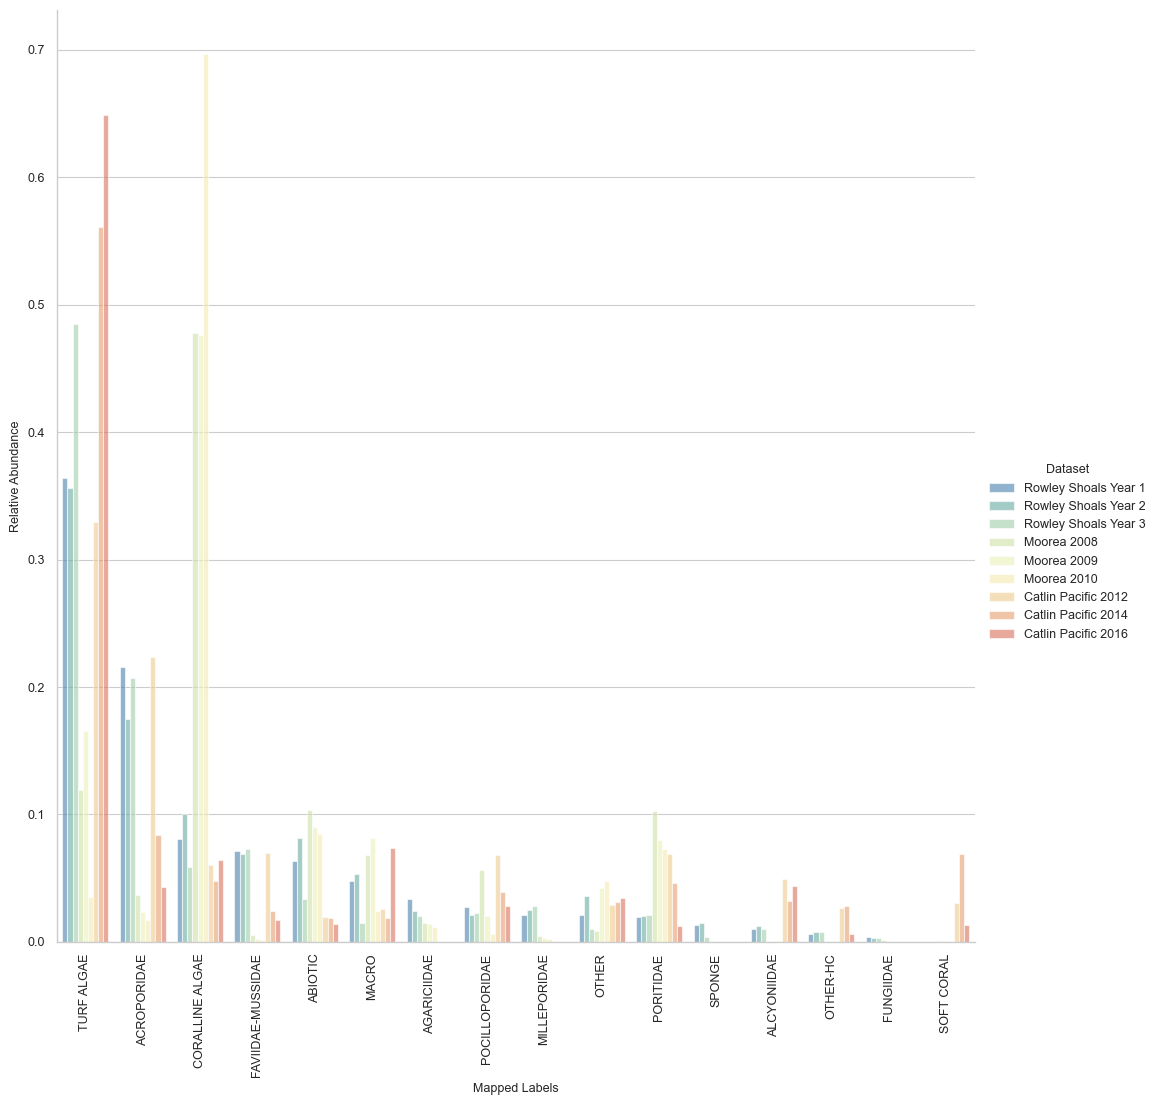

In [13]:
count_frames["Mapped Labels"] = count_frames["label"]
count_frames["Relative Abundance"] = count_frames["proportion"]
count_frames["Dataset"] = count_frames["dataset"]

cp = sns.color_palette("Spectral", 10)
cp.reverse()

g = sns.catplot(
    data=count_frames, kind="bar",
    x="Mapped Labels", y="Relative Abundance", hue="Dataset",
    alpha=.6, height=10, palette=cp
)

plt.xticks(rotation=90)

g.savefig("class_abundance_plot.png", format="png", dpi=300)

### UMAP plot comparing datasets Rowleys/Morea

In [14]:
index = np.random.choice(X_6854.shape[0], 1000, replace=False)
samp = X_6854[index]
reducer = umap.UMAP()
embedding = reducer.fit_transform(samp)
embedding.shape

(1000, 2)

In [15]:
index = np.random.choice(X_morea_2008.shape[0], 1000, replace=False)
samp = X_morea_2008[index]

embedding2 = reducer.fit_transform(samp)
embedding2.shape

(1000, 2)

In [16]:
maps = [0] * embedding.shape[0]
maps2 = [1] * embedding2.shape[0]
maps = maps + maps2

embedding3 = np.vstack((embedding, embedding2))
embedding3.shape

(2000, 2)

/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/2654517336.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/2654517336.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


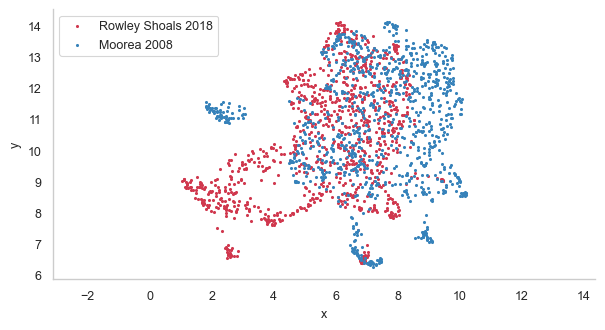

In [17]:
fig = plt.figure(figsize = (7,3.5))

cp = sns.color_palette("Spectral", 10)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=cp[0],
    label="Rowley Shoals 2018",
    s=2
)

plt.scatter(
    embedding2[:, 0],
    embedding2[:, 1],
    c=cp[9],
    label="Moorea 2008",
    s=2
)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(False)

fig.axes[0].spines['top'].set_visible(False)
fig.axes[0].spines['right'].set_visible(False)


plt.gca().set_aspect('equal', 'datalim')

plt.savefig("umap_plot.png", format="png", dpi=300)


### Histograms 

Fitting OOD estimator based on provided features ...
Rowley Shoals 2018
Fitting OOD estimator based on provided features ...
Rowley Shoals 2018-2
Fitting OOD estimator based on provided features ...
Rowley Shoals 2019
Fitting OOD estimator based on provided features ...
Catlin Pacific 2012
Fitting OOD estimator based on provided features ...
Catlin Pacific 2014
Fitting OOD estimator based on provided features ...
Catlin Pacific 2016
Fitting OOD estimator based on provided features ...
Moorea 2008
Fitting OOD estimator based on provided features ...
Moorea 2009
Fitting OOD estimator based on provided features ...
Moorea 2010
Fitting OOD estimator based on provided features ...
Moorea 2010


<Figure size 800x350 with 0 Axes>

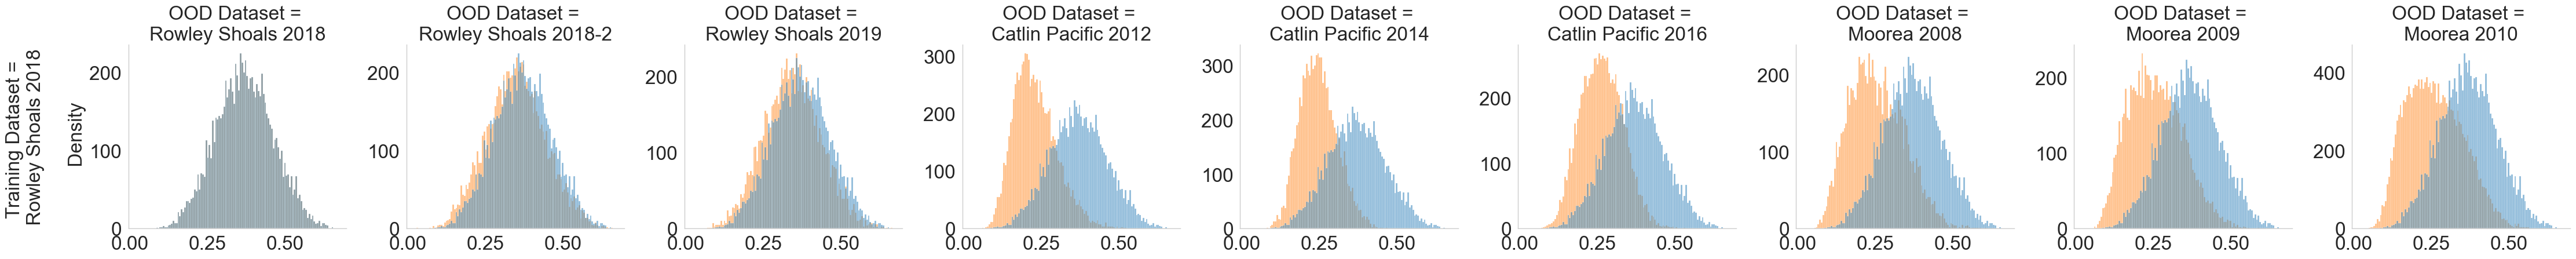

<Figure size 800x350 with 0 Axes>

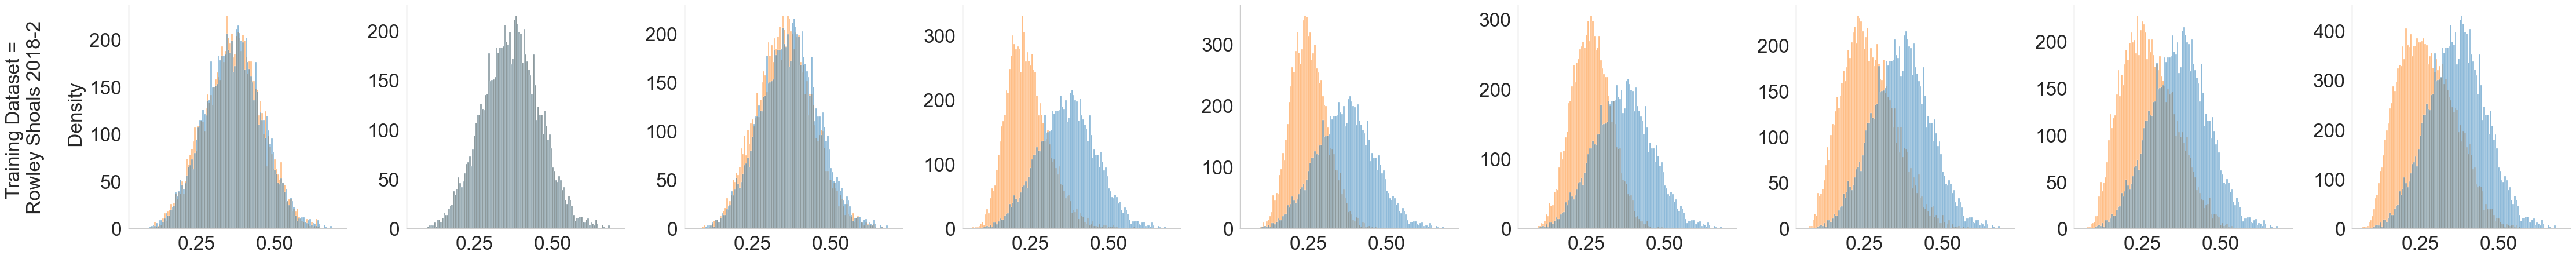

<Figure size 800x350 with 0 Axes>

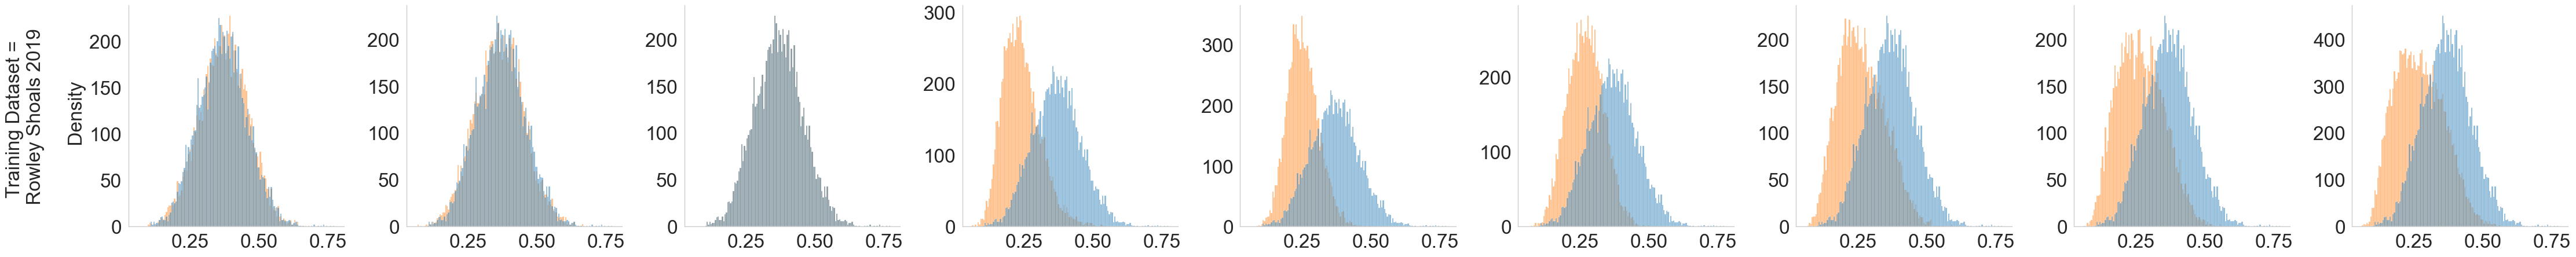

<Figure size 800x350 with 0 Axes>

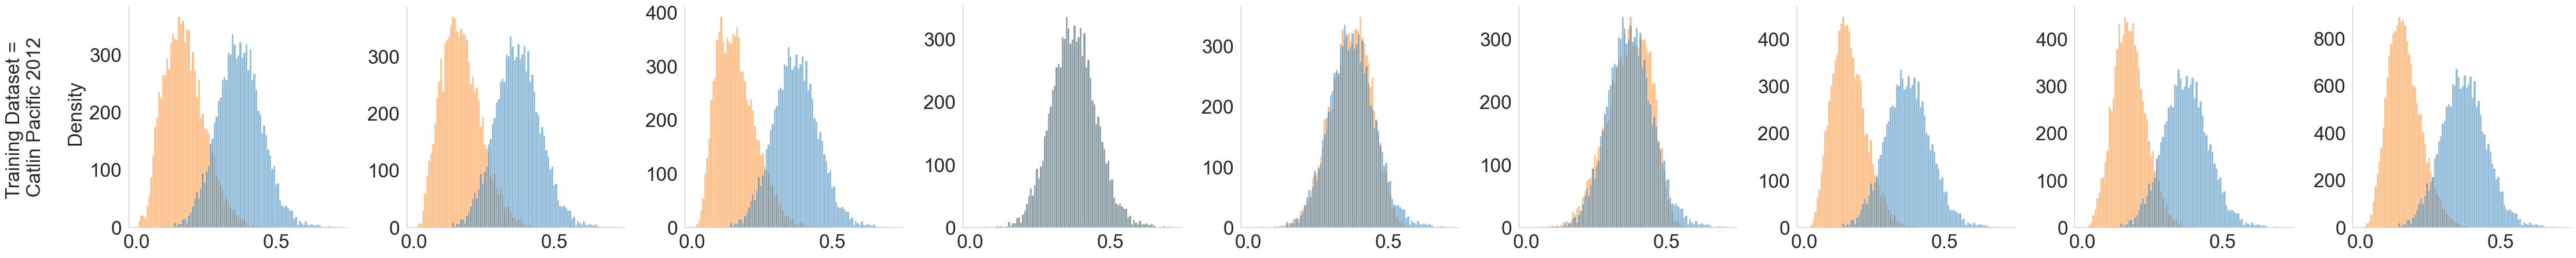

<Figure size 800x350 with 0 Axes>

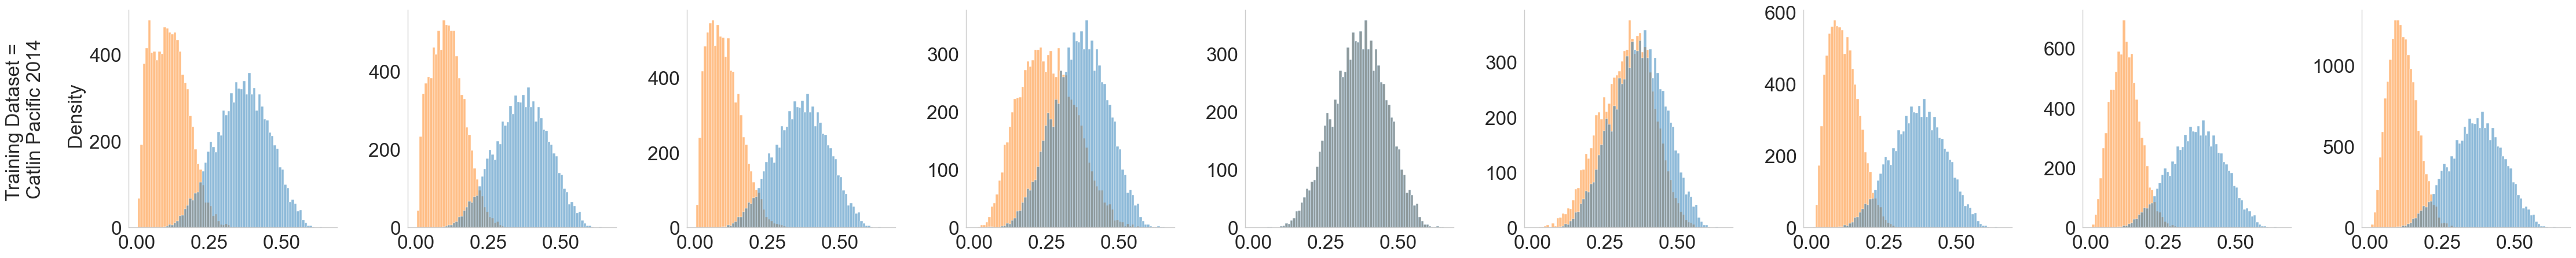

<Figure size 800x350 with 0 Axes>

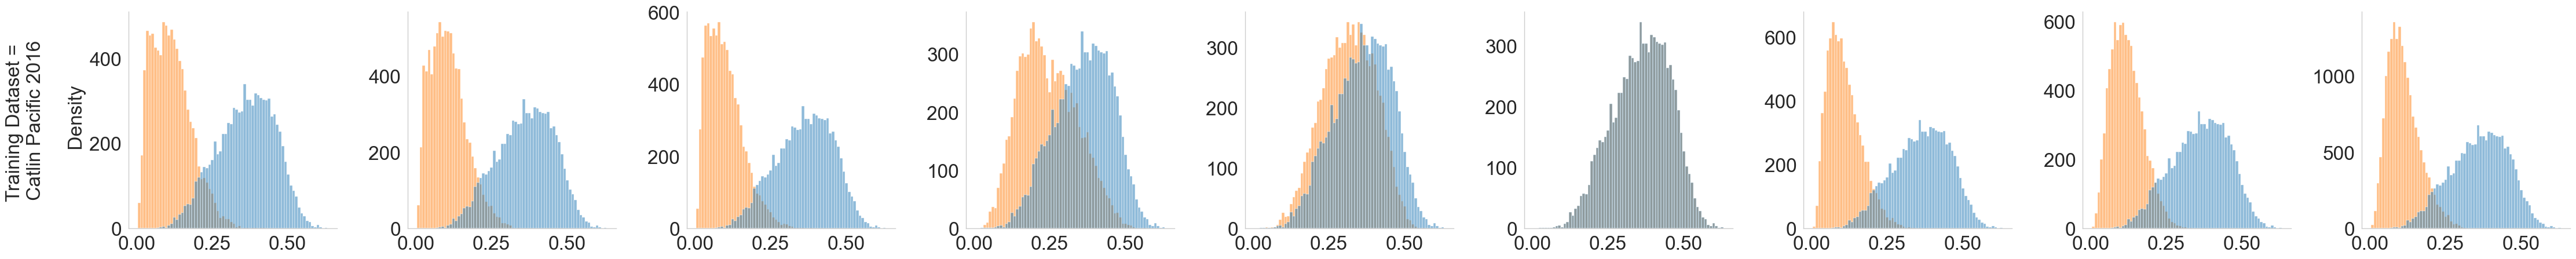

<Figure size 800x350 with 0 Axes>

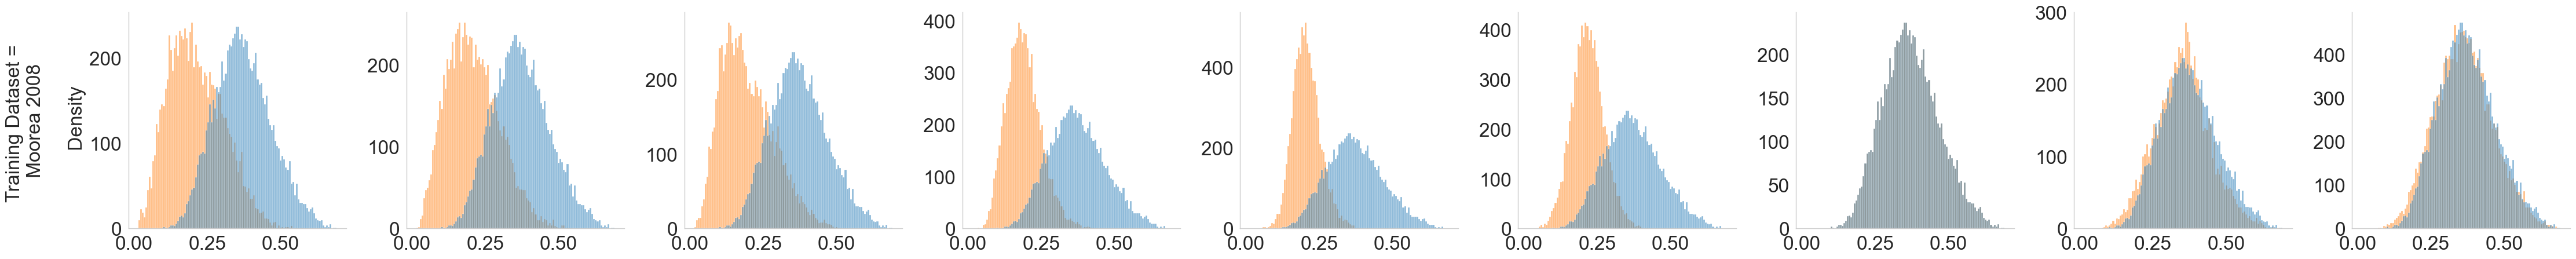

<Figure size 800x350 with 0 Axes>

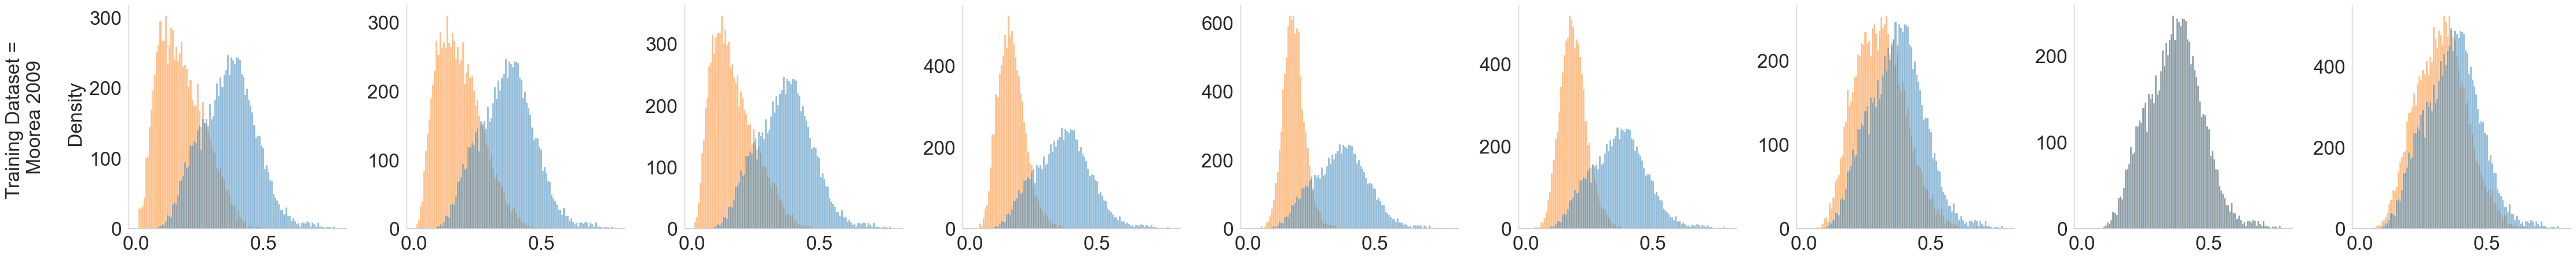

<Figure size 800x350 with 0 Axes>

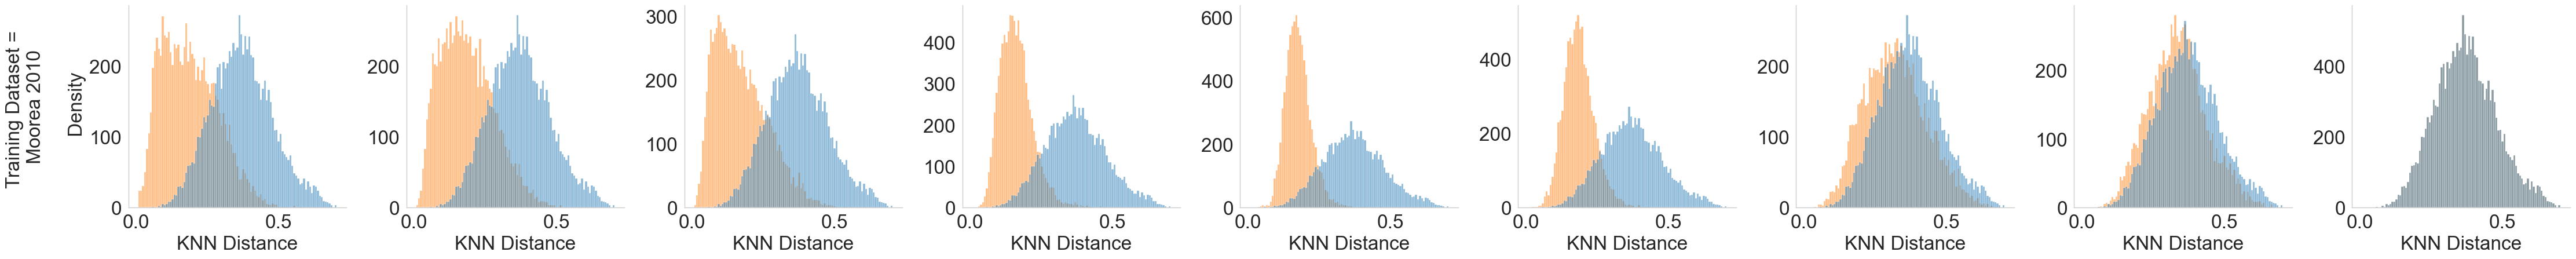

<Figure size 800x350 with 0 Axes>

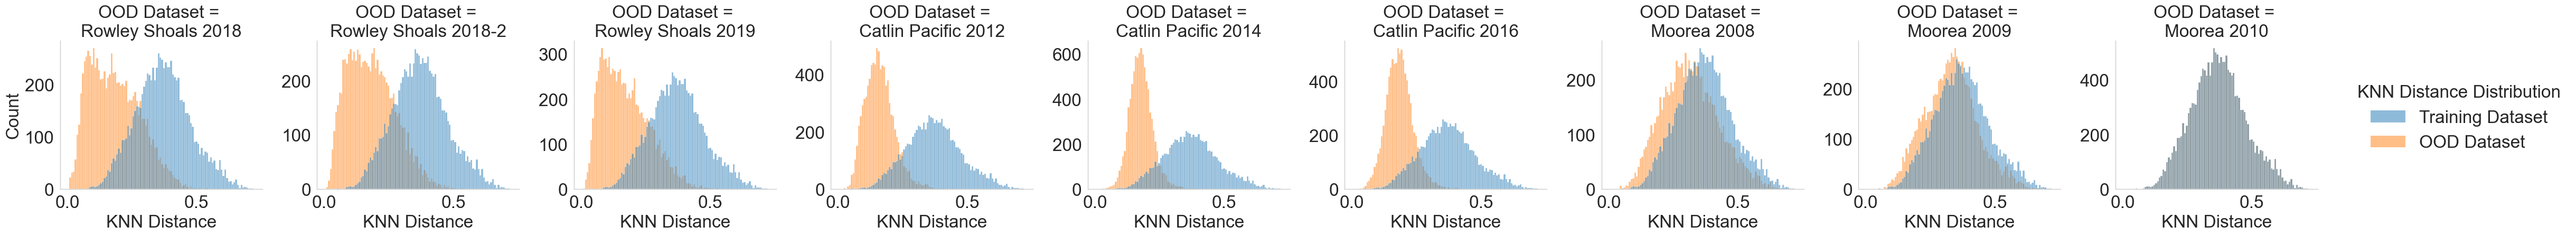

In [25]:
import PIL

sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("paper", rc={"font.size":24,"axes.titlesize":24,"axes.labelsize":24,"xtick.labelsize":24,"ytick.labelsize":24,"legend.fontsize":24,"legend.title_fontsize":24, 
                             "font.family": "sans-serif"})

sample_size = 9000
imgs = []

trips = [
    ["Rowley Shoals 2018", X_6854, y_6854],
    ["Rowley Shoals 2018-2", X_6999, y_6999],
    ["Rowley Shoals 2019", X_7255, y_7255],
    ["Catlin Pacific 2012", X_catlin_2012, y_catlin_2012],
    ["Catlin Pacific 2014", X_catlin_2014, y_catlin_2014],
    ["Catlin Pacific 2016", X_catlin_2016, y_catlin_2016],
    ["Moorea 2008", X_morea_2008, y_morea_2008],
    ["Moorea 2009", X_morea_2009, y_morea_2009],
    ["Moorea 2010", X_morea_2010, y_morea_2010],
    ["Moorea 2010", X_morea_2010, y_morea_2010],
]

for index, trip_source in enumerate(trips):
    
    plists = []
    X_trip_source = sample_X(trip_source[1], n_samples=sample_size)
    ood = OutOfDistribution()
    #ood = CustomOOD()
    #train_scores = ood.fit_score(features=sample_X(X_trip_source, n_samples=10000))
    train_scores = ood.fit_score(features=X_trip_source)
    print(trip_source[0])

    for trip in trips:
        
        if trip == trip_source:
            ood_scores = train_scores
        else:    
            X_trip = sample_X(trip[1], n_samples=sample_size)
            ood_scores = ood.score(features=X_trip)

        scores1 = train_scores
        scores2 = ood_scores

        percentile_list = pd.DataFrame(
            {'KNN Distance': scores1,
            'KNN Distance Distribution': ["Training Dataset"] * len(scores1),
            'OOD Dataset': "\n" + trip[0],
            'Training Dataset': trip_source[0]
            })

        percentile_list2 = pd.DataFrame(
            {'KNN Distance': scores2,
            'KNN Distance Distribution': ["OOD Dataset"] * len(scores2),
            'OOD Dataset': "\n" + trip[0],
            'Training Dataset': trip_source[0]
            })

        #percentile_list = pd.concat([percentile_list, percentile_list2])
        plists.append(percentile_list)
        plists.append(percentile_list2)

    percentile_list = pd.concat(plists)      

    fig = plt.figure(figsize = (8,3.5))

    if index == 9:
        g = sns.displot(percentile_list, x="KNN Distance", hue="KNN Distance Distribution", col="OOD Dataset", col_wrap=9, common_norm=True, fill=True, facet_kws={'sharey': False, 'sharex': True})
        g.legend.get_frame().set_edgecolor('black')  # Set the border color
        g.legend.get_frame().set_linewidth(1.5)      # Set the border width

        fig = plt.gcf()
        #plt.tight_layout()
        fig.savefig("legend-distplot.png", format="png", dpi=300)
        
        #img = PIL.Image.open("legend-distplot.png" % trip_source[0])
        #imgs.append(img)    

        continue 

    g = sns.displot(percentile_list, x="KNN Distance", hue="KNN Distance Distribution", col="OOD Dataset", col_wrap=9, common_norm=True, fill=True, facet_kws={'sharey': False, 'sharex': True}, legend=False)
    g.set_ylabels("Training Dataset = \n %s \n \n Density" % trip_source[0])
    
    if index > 0:
        g.set_titles(col_template="")
        #g.legend.remove() 

    if index < 8:
        g.set(xlabel=None)

    #if index == 8:
        #sns.move_legend(g, "upper left", bbox_to_anchor=(.4, 0))
        #g.legend.set(loc="upper left", bbox_to_anchor=(.4, 0))
          
         
    #g.legend.savefig('legend_only.png', bbox_inches='tight', dpi=300)
    #g.legend.remove()
    fig = plt.gcf()
    plt.tight_layout()
    fig.savefig("%s-distplot.png" % trip_source[0], format="png", dpi=300)
    
    img = PIL.Image.open("%s-distplot.png" % trip_source[0])
    imgs.append(img)
    

imgs_comb = np.vstack( imgs )
imgs_comb = PIL.Image.fromarray( imgs_comb)
imgs_comb.save( 'combined_dist.png', dpi=(300, 300) )


### Class histograms

Rowley Shoals 2018


/Users/mat/Dev/safeai-for-coral-reefs-public/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting OOD estimator based on provided features ...
Rowley Shoals 2018-2


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Rowley Shoals 2018-2 ABIOTIC 0.8050681629896187
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Rowley Shoals 2018-2 ACROPORIDAE 0.8515869107308804
Fitting OOD estimator based on provided features ...
Rowley Shoals 2018-2 AGARICIIDAE 0.7209015826531613
Fitting OOD estimator based on provided features ...
Rowley Shoals 2018-2 ALCYONIIDAE 0.4345612973643351
Fitting OOD estimator based on provided features ...
Rowley Shoals 2018-2 CORALLINE ALGAE 0.7976653319529142
Fitting OOD estimator based on provided features ...
Rowley Shoals 2018-2 FAVIIDAE-MUSSIDAE 0.8156241385625925
Fitting OOD estimator based on provided features ...
Rowley Shoals 2018-2 FUNGIIDAE 0.16607180565409674
Fitting OOD estimator based on provided features ...
Rowley Shoals 2018-2 MACRO 0.7928132697243433
Fitting OOD estimator based on provided features ...
Rowley Shoals 2018-2 MILLEPORIDAE 0.587037658867142
Fitting OOD estimator based on provided features ...
Rowley Shoals 2018-2 OTHER 0.7345980299369217
Fitting OOD estimator based on provided features ...
Rowley Shoals 2018-2 OTHER-HC 0.191233000450938
Fitting OO

/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Rowley Shoals 2018-2 POCILLOPORIDAE 0.6872604638598345
Fitting OOD estimator based on provided features ...
Rowley Shoals 2018-2 PORITIDAE 0.6714679402344249
Fitting OOD estimator based on provided features ...
Rowley Shoals 2018-2 SPONGE 0.476216759767619
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Rowley Shoals 2018-2 TURF ALGAE 0.8675700047350577
Rowley Shoals 2019


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Rowley Shoals 2019 ABIOTIC 0.7715297216801373
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Rowley Shoals 2019 ACROPORIDAE 0.8727050939764704
Fitting OOD estimator based on provided features ...
Rowley Shoals 2019 AGARICIIDAE 0.6787196814481123
Fitting OOD estimator based on provided features ...
Rowley Shoals 2019 ALCYONIIDAE 0.5355162225507208
Fitting OOD estimator based on provided features ...
Rowley Shoals 2019 CORALLINE ALGAE 0.8051768456734896
Fitting OOD estimator based on provided features ...
Rowley Shoals 2019 FAVIIDAE-MUSSIDAE 0.8086235390290888
Fitting OOD estimator based on provided features ...
Rowley Shoals 2019 FUNGIIDAE 0.18439663386346186
Fitting OOD estimator based on provided features ...
Rowley Shoals 2019 MACRO 0.7756198803117537
Fitting OOD estimator based on provided features ...
Rowley Shoals 2019 MILLEPORIDAE 0.6447812461315781
Fitting OOD estimator based on provided features ...
Rowley Shoals 2019 OTHER 0.6556709689069962
Fitting OOD estimator based on provided features ...
Rowley Shoals 2019 OTHER-HC 0.324021709327622
Fitting OOD estimator based o

/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Rowley Shoals 2019 TURF ALGAE 0.8270768465688749
Catlin Pacific 2012


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Catlin Pacific 2012 ABIOTIC 0.23891801105556576
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Catlin Pacific 2012 ACROPORIDAE 0.1766462955082007
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Catlin Pacific 2012 ALCYONIIDAE 0.34787619964259275
Fitting OOD estimator based on provided features ...
Catlin Pacific 2012 CORALLINE ALGAE 0.5574027375843837
Fitting OOD estimator based on provided features ...
Catlin Pacific 2012 FAVIIDAE-MUSSIDAE 0.2762870802284121
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Catlin Pacific 2012 MACRO 0.48341713748268544
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Catlin Pacific 2012 OTHER 0.49649349144509713
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Catlin Pacific 2012 OTHER-HC 0.160808066765602
Fitting OOD estimator based on provided features ...
Catlin Pacific 2012 POCILLOPORIDAE 0.0935217632984162
Fitting OOD estimator based on provided features ...
Catlin Pacific 2012 PORITIDAE 0.4820164772021814
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Catlin Pacific 2012 TURF ALGAE 0.44824980751619425
Catlin Pacific 2014


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Catlin Pacific 2014 ABIOTIC 0.31188775185293294
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Catlin Pacific 2014 ACROPORIDAE 0.12689427151401947
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Catlin Pacific 2014 ALCYONIIDAE 0.1659321906711683
Fitting OOD estimator based on provided features ...
Catlin Pacific 2014 CORALLINE ALGAE 0.3788955379566805
Fitting OOD estimator based on provided features ...
Catlin Pacific 2014 FAVIIDAE-MUSSIDAE 0.0810675992868941
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Catlin Pacific 2014 MACRO 0.4951704394922085
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Catlin Pacific 2014 OTHER 0.5185112456865089
Fitting OOD estimator based on provided features ...
Catlin Pacific 2014 OTHER-HC 0.036976679612315114
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Catlin Pacific 2014 POCILLOPORIDAE 0.0129492853534541
Fitting OOD estimator based on provided features ...
Catlin Pacific 2014 PORITIDAE 0.345445765890494
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Catlin Pacific 2014 TURF ALGAE 0.41099868629484015
Catlin Pacific 2016


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Catlin Pacific 2016 ABIOTIC 0.44242711975510896
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Catlin Pacific 2016 ACROPORIDAE 0.15732753838624935
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Catlin Pacific 2016 ALCYONIIDAE 0.09876313806952605
Fitting OOD estimator based on provided features ...
Catlin Pacific 2016 CORALLINE ALGAE 0.5042025059635704
Fitting OOD estimator based on provided features ...
Catlin Pacific 2016 FAVIIDAE-MUSSIDAE 0.1706995526285111
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Catlin Pacific 2016 MACRO 0.5692167738239937
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Catlin Pacific 2016 OTHER 0.5699680132803817
Fitting OOD estimator based on provided features ...
Catlin Pacific 2016 OTHER-HC 0.02918034632542721
Fitting OOD estimator based on provided features ...
Catlin Pacific 2016 POCILLOPORIDAE 0.0074611548980672735
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Catlin Pacific 2016 PORITIDAE 0.3821918818969736
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Catlin Pacific 2016 TURF ALGAE 0.5050393199251034
Moorea 2008


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Moorea 2008 ABIOTIC 0.6978069628387552
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Moorea 2008 ACROPORIDAE 0.23524610694641795
Fitting OOD estimator based on provided features ...
Moorea 2008 AGARICIIDAE 0.13149842766309605
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Moorea 2008 CORALLINE ALGAE 0.6523244487375082
Fitting OOD estimator based on provided features ...
Moorea 2008 FAVIIDAE-MUSSIDAE -0.007773110537475487
Fitting OOD estimator based on provided features ...
Moorea 2008 FUNGIIDAE 0.13894064564124428
Fitting OOD estimator based on provided features ...
Moorea 2008 MACRO 0.5787893205333866
Fitting OOD estimator based on provided features ...
Moorea 2008 MILLEPORIDAE 0.2054435003905
Fitting OOD estimator based on provided features ...
Moorea 2008 OTHER 0.6597458413026642
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Moorea 2008 POCILLOPORIDAE 0.3410861493586964
Fitting OOD estimator based on provided features ...
Moorea 2008 PORITIDAE 0.440

/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Moorea 2008 TURF ALGAE 0.5195213533934
Moorea 2009


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Moorea 2009 ABIOTIC 0.7273508517269036
Fitting OOD estimator based on provided features ...
Moorea 2009 ACROPORIDAE 0.2234661433893187
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Moorea 2009 AGARICIIDAE 0.17207740027292948
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Moorea 2009 CORALLINE ALGAE 0.640447023129712
Fitting OOD estimator based on provided features ...
Moorea 2009 FAVIIDAE-MUSSIDAE 0.027121523863320784
Fitting OOD estimator based on provided features ...
Moorea 2009 FUNGIIDAE 0.16385514795493072
Fitting OOD estimator based on provided features ...
Moorea 2009 MACRO 0.5828632657784802
Fitting OOD estimator based on provided features ...
Moorea 2009 MILLEPORIDAE 0.16884538919065772
Fitting OOD estimator based on provided features ...
Moorea 2009 OTHER 0.6162506012576172
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Moorea 2009 POCILLOPORIDAE 0.19139455359980967
Fitting OOD estimator based on provided features ...
Moorea 2009 PORITIDAE 0.4084916888233099
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based

/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Moorea 2009 TURF ALGAE 0.5559897158797524
Moorea 2010


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Moorea 2010 ABIOTIC 0.7016882495729417
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Moorea 2010 ACROPORIDAE 0.1465238829763564
Fitting OOD estimator based on provided features ...
Moorea 2010 AGARICIIDAE 0.1840551626741985
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Moorea 2010 CORALLINE ALGAE 0.7040438313928925
Fitting OOD estimator based on provided features ...
Moorea 2010 FAVIIDAE-MUSSIDAE 0.03901038807961587
Fitting OOD estimator based on provided features ...
Moorea 2010 FUNGIIDAE 0.13104195497930524
Fitting OOD estimator based on provided features ...
Moorea 2010 MACRO 0.6326596354516263
Fitting OOD estimator based on provided features ...
Moorea 2010 MILLEPORIDAE 0.08869583201842934
Fitting OOD estimator based on provided features ...
Moorea 2010 OTHER 0.6079591577015746
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Moorea 2010 POCILLOPORIDAE 0.10907262473544224
Fitting OOD estimator based on provided features ...
Moorea 2010 PORITIDAE 0.43

/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Moorea 2010 TURF ALGAE 0.5569663263552775


<Figure size 800x350 with 0 Axes>

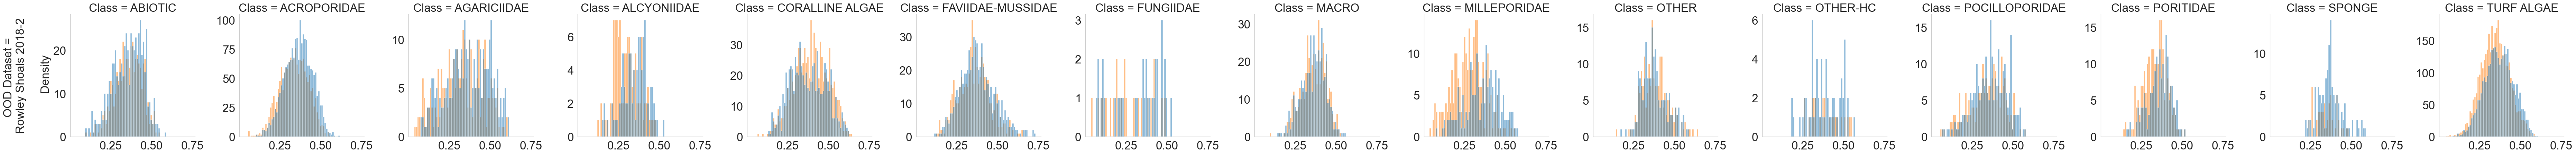

<Figure size 800x350 with 0 Axes>

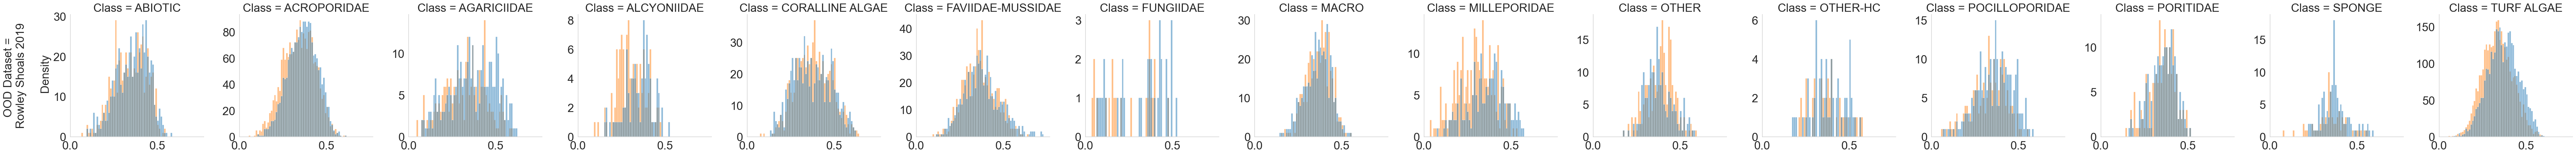

<Figure size 800x350 with 0 Axes>

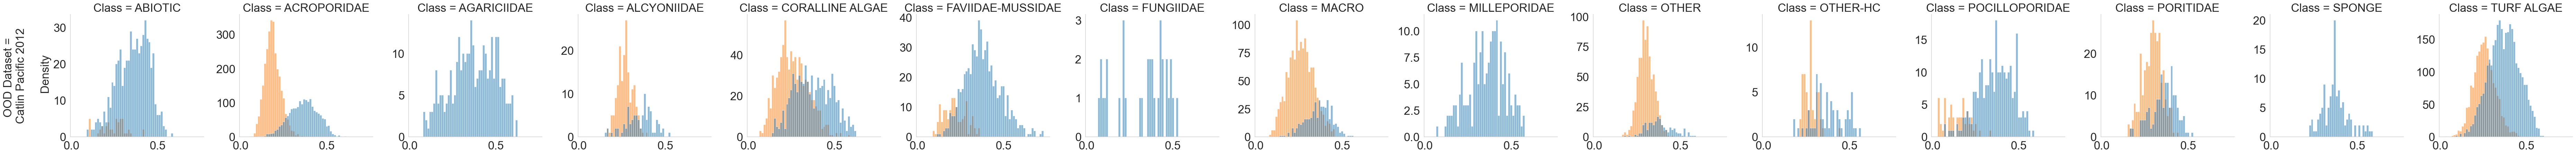

<Figure size 800x350 with 0 Axes>

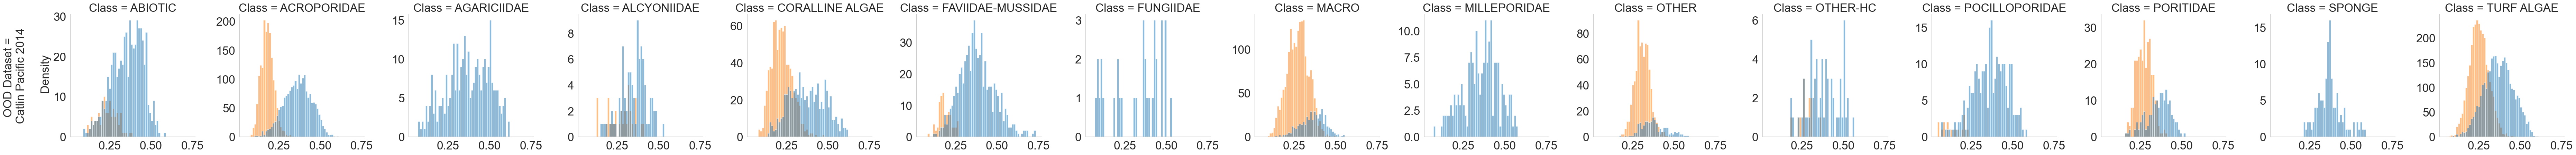

<Figure size 800x350 with 0 Axes>

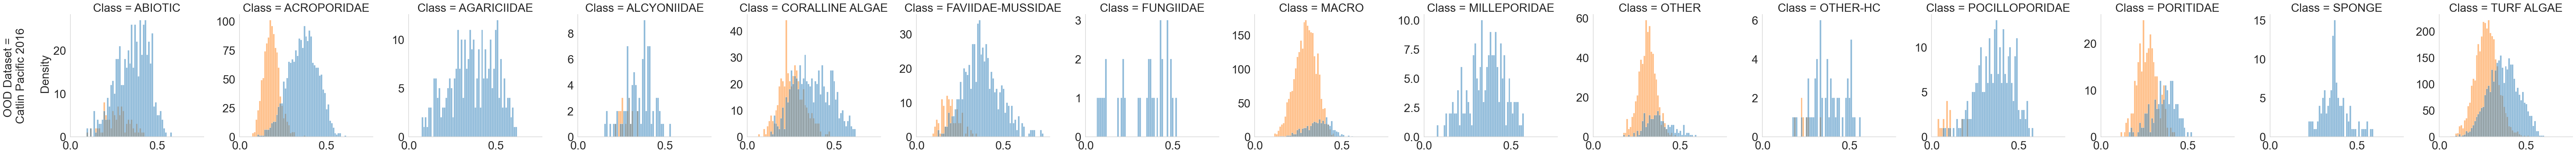

<Figure size 800x350 with 0 Axes>

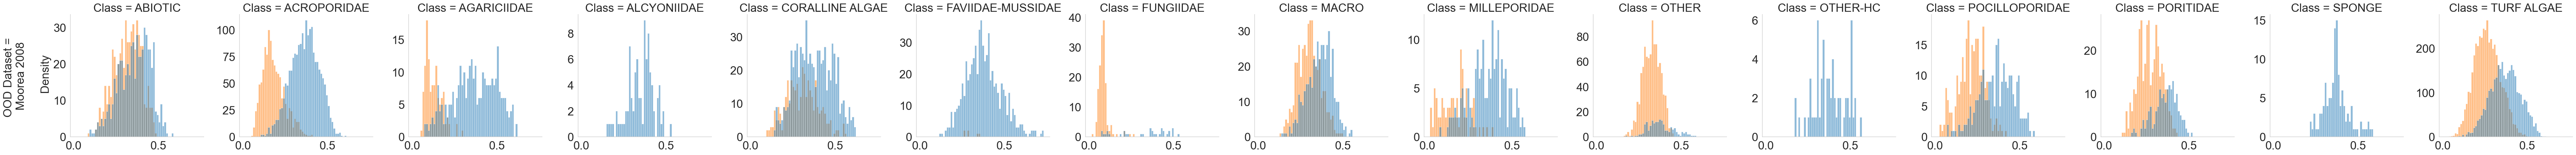

<Figure size 800x350 with 0 Axes>

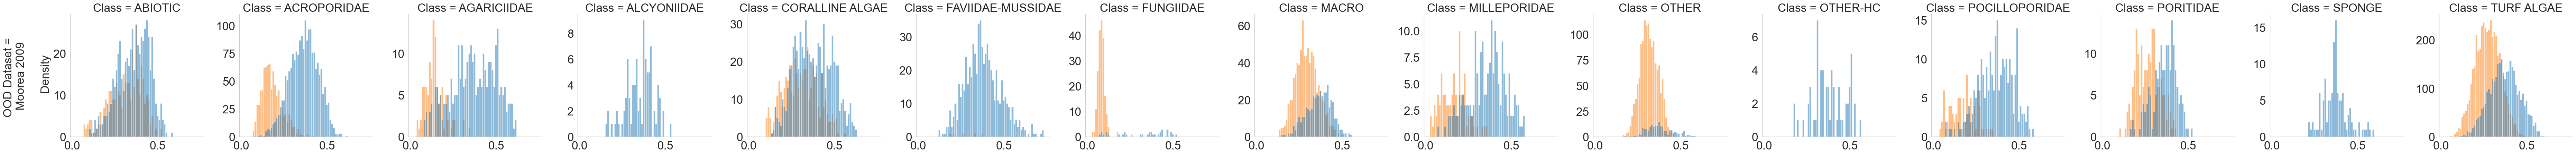

<Figure size 800x350 with 0 Axes>

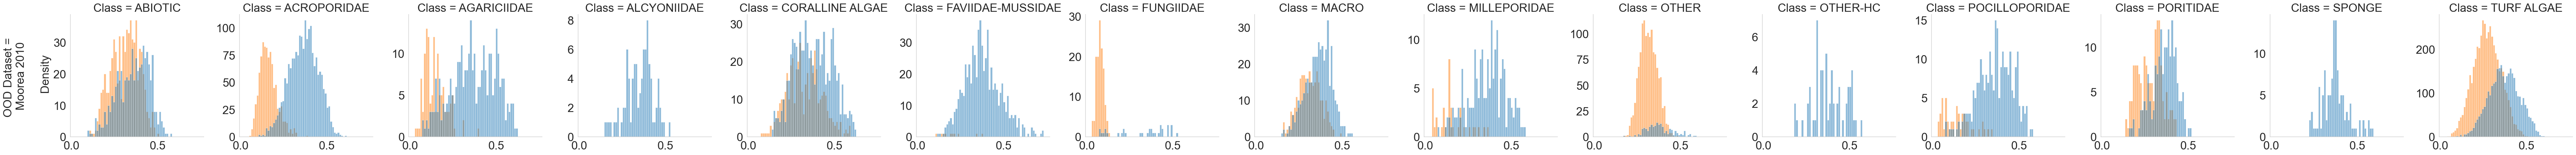

In [26]:

sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("paper", rc={"font.size":24,"axes.titlesize":24,"axes.labelsize":24,"xtick.labelsize":24,"ytick.labelsize":24,"legend.fontsize":24,"legend.title_fontsize":24, 
                             "font.family": "sans-serif"})

sample_size = 9000
correlations_f1 = []
plists = []
imgs = []
class_histogram_overlap = {}
f1_heatmap_dict = {}
heatmap_dfs = []

# the datasets here 
trips = [
    ["Rowley Shoals 2018", X_6854, y_6854],
    ["Rowley Shoals 2018-2", X_6999, y_6999],
    ["Rowley Shoals 2019", X_7255, y_7255],
    ["Catlin Pacific 2012", X_catlin_2012, y_catlin_2012],
    ["Catlin Pacific 2014", X_catlin_2014, y_catlin_2014],
    ["Catlin Pacific 2016", X_catlin_2016, y_catlin_2016],
    ["Moorea 2008", X_morea_2008, y_morea_2008],
    ["Moorea 2009", X_morea_2009, y_morea_2009],
    ["Moorea 2010", X_morea_2010, y_morea_2010],
]

# for each of the datasets
for index, trip in enumerate(trips[0:1]):
    print(trip[0])
    X_trip, y_trip = sample_Xy(trip[1], trip[2], n_samples=sample_size)

    ## train a model for the dataset 
    model = LogisticRegression(random_state=0, max_iter=100)
    model.fit(np.asarray(X_trip), np.asarray(y_trip))

    ## train an ood model for the dataset 
    ood = OutOfDistribution()
    #ood = CustomOOD()
    train_scores = ood.fit_score(features=X_trip)

    for trip_compare in trips[1:]:
        print(trip_compare[0])
        X_trip_compare, y_trip_compare = sample_Xy(trip_compare[1], trip_compare[2], n_samples=sample_size)
        
        ## get f1 score for the dataset and confidence 
        pred = model.predict(X_trip_compare)
        pred_probs = model.predict_proba(X_trip_compare)
        f1 = f1_score(y_trip_compare, pred, average='weighted')
        
        ## get distance for the dataset 
        ood_scores = ood.score(features=X_trip_compare)
        hidd_global = calculate_hidd(train_scores, ood_scores)
        

        df1 = {}
        df1["f1_score"] = f1
        df1["hidd_global"] = hidd_global
        df1["trip"] = trip_compare[0]
        df1["confidence"] = np.average(np.amax(pred_probs, axis=1))
        
        correlations_f1.append(df1)

        plists = []
        hist_overlaps = []
        heatmap_f1s = []

        ## do label distance 
        for label in np.unique(y_trip):

            # get data for label 
            X_trip_for_label, y_trip_for_label = get_Xy_for_label(X_trip, y_trip, label)
            X_trip_compare_for_label, y_trip_compare_for_label = get_Xy_for_label(X_trip_compare, pred, label)
            X_true, y_true = get_Xy_for_label(X_trip_compare, y_trip_compare, label)

            #cleanlab ood
            ood = OutOfDistribution()
            #ood = CustomOOD()
            hidd_class_train_scores = ood.fit_score(features=X_trip_for_label)
            
            if len(X_trip_compare_for_label) < 2 or len(X_true) < 2:
                
                percentile_list = pd.DataFrame(
                    {'KNN Distance': hidd_class_train_scores,
                    'Distribution': ["Source Dataset"] * len(hidd_class_train_scores),
                    'Class': label,
                    'Dataset': trip_compare[0]
                    })
                plists.append(percentile_list)
                
                #hist_overlaps.append(0)
                #heatmap_f1s.append(0)

                heatmap_df = pd.DataFrame(
                    {'Histogram Intersection': 0,
                    'F1 Score': 0,
                    'Label': label,
                    'Dataset': trip_compare[0]
                    }, index=["i"])
                heatmap_dfs.append(heatmap_df)

                continue
            
            
            
            hidd_class_compare_scores = ood.score(features=X_trip_compare_for_label)
            

            scores1 = hidd_class_train_scores
            scores2 = hidd_class_compare_scores

            #hist_overlaps.append(intersection_area(scores1, scores2))
            hist_intersection = calculate_hidd(scores1, scores2)
            pred_class = model.predict(X_true)
            f1_class = f1_score(y_true, pred_class, average='weighted')
            #heatmap_f1s.append(f1_class)

            print(trip_compare[0], label, hist_intersection)
            
            heatmap_df = pd.DataFrame(
                    {'Histogram Intersection': hist_intersection,
                    'F1 Score': f1_class,
                    'Label': label,
                    'Dataset': trip_compare[0]
                    }, index=["i"])
            heatmap_dfs.append(heatmap_df)

            percentile_list = pd.DataFrame(
                {'KNN Distance': scores1,
                'Distribution': ["Source Dataset"] * len(scores1),
                'Class': label,
                'Dataset': trip_compare[0]
                })

            percentile_list2 = pd.DataFrame(
                {'KNN Distance': scores2,
                'Distribution': ["OOD Dataset"] * len(scores2),
                'Class': label,
                'Dataset': trip_compare[0]
                })

            #percentile_list = pd.concat([percentile_list, percentile_list2])
            plists.append(percentile_list)
            plists.append(percentile_list2)
            
            #hidd_class = hidd_global_score(hidd_class_train_scores, hidd_class_compare_scores)
            #hidd_class = intersection_area(hidd_class_train_scores, hidd_class_compare_scores)

            # predict class & get f1 confidence
            #pred = model.predict(X_trip_compare_for_label)
            #pred_probs = model.predict_proba(X_trip_compare_for_label)
            #f1_class = f1_score(y_trip_compare_for_label, pred, average='weighted')
            #y_binary_class, y_single_prob_class = get_ece_inputs(sample1y_label, sample1y_pred_prob_label_flat)
            #_, _, ece_class = custom_calibration_curve(y_binary_class, y_single_prob_class)

            #np.set_printoptions(suppress=True)
        
        #class_histogram_overlap[trip_compare[0]] = hist_overlaps
        #f1_heatmap_dict[trip_compare[0]] = heatmap_f1s
        heatmap_df = pd.concat(heatmap_dfs) 
        percentile_list = pd.concat(plists)

        fig = plt.figure(figsize = (8,3.5))

        g = sns.displot(percentile_list, x="KNN Distance", hue="Distribution", col="Class", col_wrap=15, common_norm=True, fill=True, facet_kws={'sharey': False, 'sharex': True}, legend=False) 
        #g.set(ylim=(0, .5))
        g.set_ylabels("OOD Dataset = \n %s \n \n Density" % trip_compare[0])

        if index > 0:
            g.set_titles(col_template="")
            #g.legend.remove() 

        if index < 7:
            g.set(xlabel=None)
        
        #plt.show()
        fig = plt.gcf()
        plt.tight_layout()
        plt.savefig("%s-classdistplot.png" % trip_compare[0], format="png", dpi=300)
        
        img = PIL.Image.open("%s-classdistplot.png" % trip_compare[0])
        imgs.append(img)

imgs_comb = np.vstack( imgs )
imgs_comb = PIL.Image.fromarray(imgs_comb)
imgs_comb.save( 'combined_class_dist.png', dpi=(300, 300) )



### Heatmaps (class based)

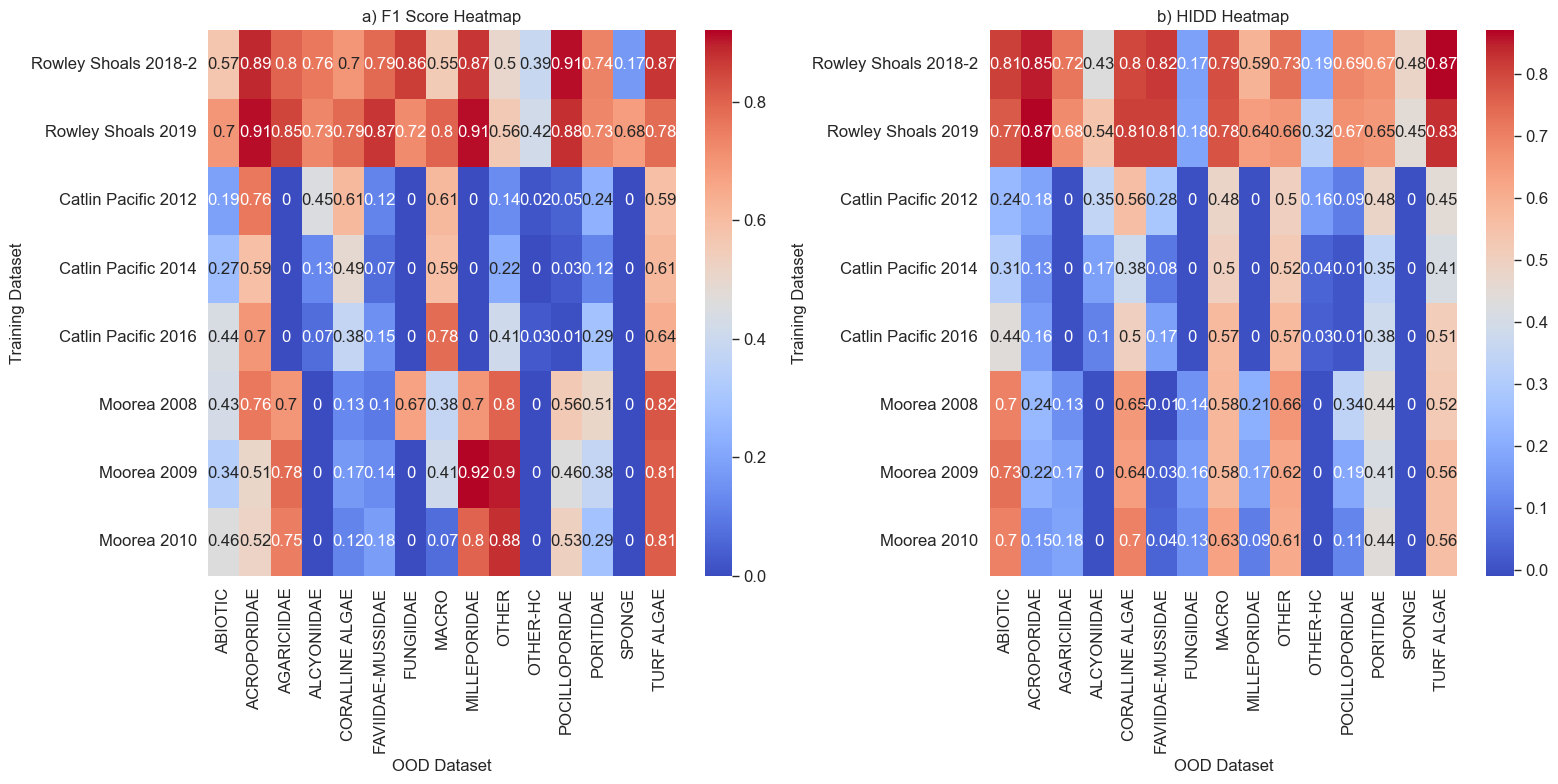

In [27]:
heatmap_df['Histogram Intersection'] = heatmap_df['Histogram Intersection'].round(2)
heatmap_df['F1 Score'] = heatmap_df['F1 Score'].round(2)


df = heatmap_df.pivot(index="Dataset", columns="Label", values="F1 Score")
df2 = heatmap_df.pivot(index="Dataset", columns="Label", values="Histogram Intersection")

new_order = [
            "Rowley Shoals 2018-2", 
            "Rowley Shoals 2019", 
            "Catlin Pacific 2012", 
            "Catlin Pacific 2014", 
            "Catlin Pacific 2016", 
            "Moorea 2008", 
            "Moorea 2009", 
            "Moorea 2010"]

df = df.reindex(new_order)
df2 = df2.reindex(new_order)

#fig = plt.figure(figsize = (8,3.5))
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12,"xtick.labelsize":12,
                             "ytick.labelsize":12,"legend.fontsize":12,"legend.title_fontsize":12,
                             "font.family": "sans-serif"})

# Create a DataFrame
#df = pd.DataFrame(data, index=['A', 'B', 'C'])
#df = heatmap_df.pivot(index="Dataset", columns="Label", values="Histogram Intersection")

#df_transposed = df.T

# Plotting the heatmap
#plt.figure(figsize=(8, 4))
#sns.heatmap(df, annot=True, cmap='coolwarm')
#plt.title('Heatmap Example')
#plt.show()

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first heatmap
sns.heatmap(df, ax=axes[0], annot=True, cmap='coolwarm')
axes[0].set_title('a) F1 Score Heatmap')
axes[0].set_ylabel('Training Dataset')
axes[0].set_xlabel('OOD Dataset')

# Plot the second heatmap
sns.heatmap(df2, ax=axes[1], annot=True, cmap='coolwarm')
axes[1].set_title('b) HIDD Heatmap')
axes[1].set_ylabel('Training Dataset')
axes[1].set_xlabel('OOD Dataset')

# Adjust layout
plt.tight_layout()

plt.savefig("heatmap_class_level.png", format="png", dpi=300)

# Show the plot
plt.show()

### Correlations 

In [28]:

sample_size = 9000
correlations_f1 = []

            
# the datasets here 
trips = [
    ["Rowley Shoals 2018", X_6854, y_6854],
    ["Rowley Shoals 2018-2", X_6999, y_6999],
    ["Rowley Shoals 2019", X_7255, y_7255],
    ["Catlin Pacific 2012", X_catlin_2012, y_catlin_2012],
    ["Catlin Pacific 2014", X_catlin_2014, y_catlin_2014],
    ["Catlin Pacific 2016", X_catlin_2016, y_catlin_2016],
    ["Moorea 2008", X_morea_2008, y_morea_2008],
    ["Moorea 2009", X_morea_2009, y_morea_2009],
    ["Moorea 2010", X_morea_2010, y_morea_2010],
]

# for each of the datasets
for trip in trips:
    print(trip[0])

    X_trip, y_trip = sample_Xy(trip[1], trip[2], n_samples=sample_size)
    #X_trip, y_trip = trip[1], trip[2]
    print(len(X_trip))
    ## train a model for the dataset 
    model = LogisticRegression(random_state=0, max_iter=100)
    model.fit(np.asarray(X_trip), np.asarray(y_trip))

    ## train an ood model for the dataset 
    ood = OutOfDistribution()
    #ood = CustomOOD()
    train_scores = ood.fit_score(features=X_trip)

    for trip_compare in trips:
        
         ## get distance for the dataset 
        if trip == trip_compare:
            ood_scores = train_scores
            X_trip_compare, y_trip_compare = X_trip, y_trip 
        else:    
            X_trip_compare, y_trip_compare = sample_Xy(trip_compare[1], trip_compare[2], n_samples=sample_size)
            ood_scores = ood.score(features=X_trip_compare)
        
        hidd_global = calculate_hidd(train_scores, ood_scores)

        print(len(X_trip_compare))

        ## get f1 score for the dataset and confidence 
        pred = model.predict(X_trip_compare)
        pred_probs = model.predict_proba(X_trip_compare)
        f1 = f1_score(y_trip_compare, pred, average='weighted')
        y_binary, y_single_prob = get_ece_inputs(y_trip_compare, pred_probs)
        _, _, ece = custom_calibration_curve(y_binary, y_single_prob)

        df1 = {}
        df1["f1_score"] = f1
        df1["ece"] = ece
        df1["hidd_global"] = hidd_global
        df1["trip"] = trip[0]
        df1["trip_compare"] = trip_compare[0]
        df1["confidence"] = np.average(np.amax(pred_probs, axis=1))
        
        correlations_f1.append(df1)

        ## do label distance 
        for label in np.unique(y_trip):

            # get data for label 
            X_trip_for_label, y_trip_for_label = get_Xy_for_label(X_trip, y_trip, label)
            X_trip_compare_for_label, y_trip_compare_for_label = get_Xy_for_label(X_trip_compare, y_trip_compare, label)

            if len(X_trip_for_label) < 20 or len(X_trip_compare_for_label) < 20:
                continue

            #cleanlab ood
            ood = OutOfDistribution()
            #ood = CustomOOD()
            hidd_class_train_scores = ood.fit_score(features=X_trip_for_label)
            hidd_class_compare_scores = ood.score(features=X_trip_compare_for_label)
            
            hidd_class = calculate_hidd(hidd_class_train_scores, hidd_class_compare_scores)

            # predict class & get f1 confidence
            pred = model.predict(X_trip_compare_for_label)
            pred_probs = model.predict_proba(X_trip_compare_for_label)
            f1_class = f1_score(y_trip_compare_for_label, pred, average='weighted')
            y_binary_class, y_single_prob_class = get_ece_inputs(y_trip_compare_for_label, pred_probs)
            _, _, ece_class = custom_calibration_curve(y_binary_class, y_single_prob_class)

            np.set_printoptions(suppress=True)

            df1 = {}
            df1["f1_score_class"] = f1_class
            df1["ece_class"] = ece_class
            df1["hidd_class"] = hidd_class
            df1["trip"] = trip[0]
            df1["trip_compare"] = trip_compare[0]
            df1["confidence_class"] = np.average(np.amax(pred_probs, axis=1))
            df1["class"] = label
            correlations_f1.append(df1)
        
correlations_f1 = pd.DataFrame.from_dict(correlations_f1)

Rowley Shoals 2018
9000


/Users/mat/Dev/safeai-for-coral-reefs-public/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Rowley Shoals 2018-2
9000


/Users/mat/Dev/safeai-for-coral-reefs-public/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Rowley Shoals 2019
9000


/Users/mat/Dev/safeai-for-coral-reefs-public/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Catlin Pacific 2012
9000


/Users/mat/Dev/safeai-for-coral-reefs-public/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Catlin Pacific 2014
9000


/Users/mat/Dev/safeai-for-coral-reefs-public/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Catlin Pacific 2016
9000


/Users/mat/Dev/safeai-for-coral-reefs-public/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Moorea 2008
9000


/Users/mat/Dev/safeai-for-coral-reefs-public/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Moorea 2009
9000


/Users/mat/Dev/safeai-for-coral-reefs-public/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Moorea 2010
9000


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/Users/mat/Dev/safeai-for-coral-reefs-public/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

9000
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
9000


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be r

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/4057421173.py:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  intersection_area = simps(intersection, bin_edges)


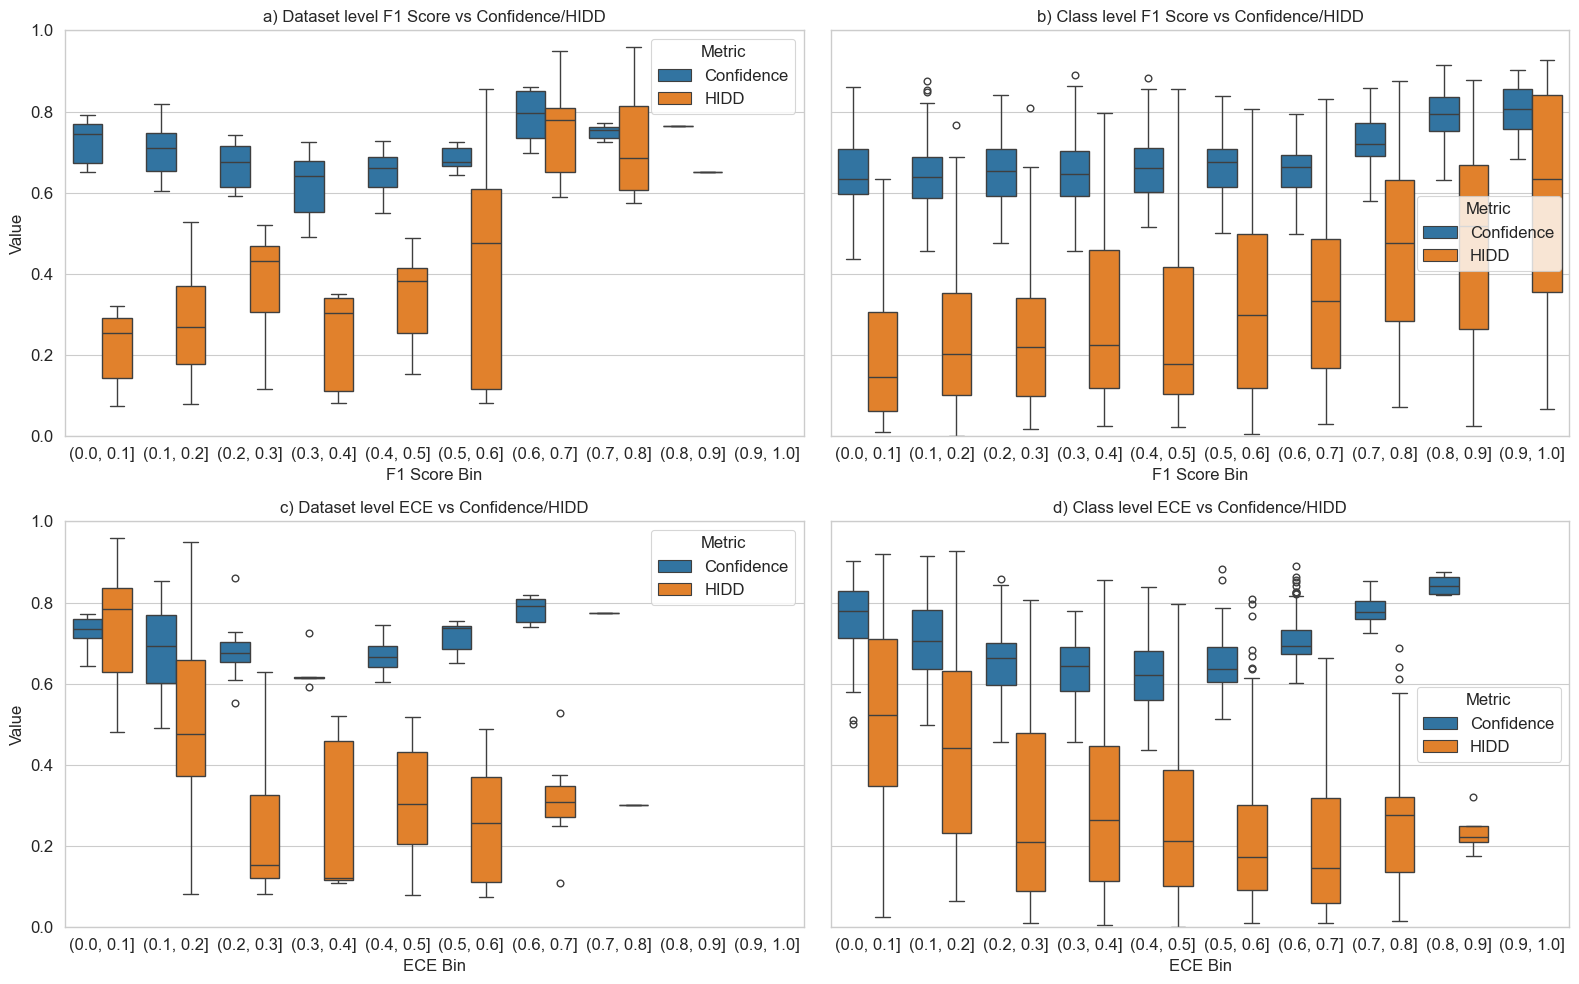

In [32]:
# drop the comprisons to the same dataset so not to bias the results
correlations_to_plot = correlations_f1[correlations_f1['trip'] != correlations_f1['trip_compare']]

sns.set_style('whitegrid')

#sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12,"xtick.labelsize":12,
                             "ytick.labelsize":12,"legend.fontsize":12,"legend.title_fontsize":12,
                             "font.family": "sans-serif"})


#colors = ['#78C850', '#F08030', '#6890F0','#F8D030', '#F85888', '#705898', '#98D8D8']
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(16,10))

melted = correlations_to_plot.melt(id_vars=['f1_score'], value_vars=['confidence', 'hidd_global'])
melted = melted.dropna()

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
melted['F1 Score Bin'] = pd.cut(melted['f1_score'], bins=bins)

melted["F1 Score"] = melted["f1_score"]
#melted["Histogram Intersection"] = melted["hidd_global"] 
#melted["Confidence"] = melted["confidence"] 
melted["Level"] = "Dataset"
melted["Metric"] = melted["variable"]
melted['Metric'] = melted['Metric'].replace('confidence', 'Confidence')
melted['Metric'] = melted['Metric'].replace('hidd_global', 'HIDD')


melted2 = correlations_to_plot.melt(id_vars=['f1_score_class'], value_vars=['confidence_class', 'hidd_class'])
melted2 = melted2.dropna()

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
melted2['F1 Score Bin'] = pd.cut(melted2['f1_score_class'], bins=bins)

melted2["F1 Score"] = melted2["f1_score_class"] 
#melted2["Histogram Intersection"] = melted["hidd_class"]
#melted2["Confidence"] = melted["confidence_class"]  
melted2["Level"] = "Class"
melted2["Metric"] = melted2["variable"]
melted2['Metric'] = melted2['Metric'].replace('confidence_class', 'Confidence')
melted2['Metric'] = melted2['Metric'].replace('hidd_class', 'HIDD')

#melted = pd.concat([melted, melted2])

#ax = sns.lmplot(data=melted, y='value', x='F1 Score', hue="Metric", col="Level", x_estimator=np.mean)

sns.boxplot(x='F1 Score Bin', y='value', hue='Metric', data=melted, ax=axes[0, 0])
sns.boxplot(x='F1 Score Bin', y='value', hue='Metric', data=melted2, ax=axes[0, 1])

axes[0, 0].set(ylabel = 'Value')
axes[0, 1].set(ylabel = 'Value')

axes[0, 0].set_title('a) Dataset level F1 Score vs Confidence/HIDD')
axes[0, 1].set_title('b) Class level F1 Score vs Confidence/HIDD')

#ax.set(ylim=(0, 1))
#ax.set(xlim=(0, 1))

melted = correlations_to_plot.melt(id_vars=['ece'], value_vars=['confidence' ,'hidd_global'])
melted = melted.dropna()

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
melted['ECE Bin'] = pd.cut(melted['ece'], bins=bins)

melted["ECE"] = melted["ece"] 
#melted["F1 Score"] = melted["f1_score"]
#melted["Histogram Intersection"] = melted["hidd_global"] 
#melted["Confidence"] = melted["confidence"] 
melted["Level"] = "Dataset"
melted["Metric"] = melted["variable"]
melted['Metric'] = melted['Metric'].replace('confidence', 'Confidence')
melted['Metric'] = melted['Metric'].replace('hidd_global', 'HIDD')

melted2 = correlations_to_plot.melt(id_vars=['ece_class'], value_vars=['confidence_class', 'hidd_class'])
melted2 = melted2.dropna()

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
melted2['ECE Bin'] = pd.cut(melted2['ece_class'], bins=bins)

melted2["ECE"] = melted2["ece_class"] 
#melted2["Histogram Intersection"] = melted["hidd_class"]
#melted2["Confidence"] = melted["confidence_class"]  
melted2["Level"] = "Class"
melted2["Metric"] = melted2["variable"]
melted2['Metric'] = melted2['Metric'].replace('confidence_class', 'Confidence')
melted2['Metric'] = melted2['Metric'].replace('hidd_class', 'HIDD')

sns.boxplot(x='ECE Bin', y='value', hue='Metric', data=melted, ax=axes[1, 0])
sns.boxplot(x='ECE Bin', y='value', hue='Metric', data=melted2, ax=axes[1, 1])

axes[1, 0].set(ylim=(0, 1))
axes[0, 1].set(ylim=(0, 1))
axes[0, 0].set(ylim=(0, 1))
axes[1, 1].set(ylim=(0, 1))

axes[1, 0].set(ylabel = 'Value')
axes[1, 1].set(ylabel = 'Value')

axes[1, 0].set_title('c) Dataset level ECE vs Confidence/HIDD')
axes[1, 1].set_title('d) Class level ECE vs Confidence/HIDD')

plt.subplots_adjust(hspace=0.3) 

plt.tight_layout()
plt.savefig("metric_correlation_boxplots.png", format="png", dpi=300)




In [30]:
binned = correlations_to_plot.copy()

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
binned['F1 Score Bin'] = pd.cut(binned['f1_score'], bins=bins)
binned['ECE Bin'] = pd.cut(binned['ece'], bins=bins)
binned['F1 Score Bin Class'] = pd.cut(binned['f1_score_class'], bins=bins)
binned['ECE Bin Class'] = pd.cut(binned['ece_class'], bins=bins)
#binned = binned.dropna()

median_values = binned.groupby('F1 Score Bin')["confidence"].median()
print(median_values)

median_values = binned.groupby('F1 Score Bin Class')["confidence_class"].median()
print(median_values)

median_values = binned.groupby('F1 Score Bin')["hidd_global"].median()
print(median_values)

median_values = binned.groupby('F1 Score Bin Class')["hidd_class"].median()
print(median_values)

median_values = binned.groupby('ECE Bin')["confidence"].median()
print(median_values)

median_values = binned.groupby('ECE Bin Class')["confidence_class"].median()
print(median_values)

median_values = binned.groupby('ECE Bin')["hidd_global"].median()
print(median_values)

median_values = binned.groupby('ECE Bin Class')["hidd_class"].median()
print(median_values)


F1 Score Bin
(0.0, 0.1]    0.744459
(0.1, 0.2]    0.709219
(0.2, 0.3]    0.676289
(0.3, 0.4]    0.642156
(0.4, 0.5]    0.661111
(0.5, 0.6]    0.676667
(0.6, 0.7]    0.796073
(0.7, 0.8]    0.755632
(0.8, 0.9]    0.763675
(0.9, 1.0]         NaN
Name: confidence, dtype: float64
F1 Score Bin Class
(0.0, 0.1]    0.634339
(0.1, 0.2]    0.639384
(0.2, 0.3]    0.654334
(0.3, 0.4]    0.645058
(0.4, 0.5]    0.660948
(0.5, 0.6]    0.675013
(0.6, 0.7]    0.663705
(0.7, 0.8]    0.719121
(0.8, 0.9]    0.794794
(0.9, 1.0]    0.806524
Name: confidence_class, dtype: float64
F1 Score Bin
(0.0, 0.1]    0.253470
(0.1, 0.2]    0.269186
(0.2, 0.3]    0.431382
(0.3, 0.4]    0.303961
(0.4, 0.5]    0.381398
(0.5, 0.6]    0.475515
(0.6, 0.7]    0.777848
(0.7, 0.8]    0.684980
(0.8, 0.9]    0.650573
(0.9, 1.0]         NaN
Name: hidd_global, dtype: float64
F1 Score Bin Class
(0.0, 0.1]    0.144084
(0.1, 0.2]    0.202654
(0.2, 0.3]    0.218832
(0.3, 0.4]    0.223366
(0.4, 0.5]    0.176219
(0.5, 0.6]    0.299065
(0

/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/2009884181.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_values = binned.groupby('F1 Score Bin')["confidence"].median()
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/2009884181.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_values = binned.groupby('F1 Score Bin Class')["confidence_class"].median()
/var/folders/bq/mfq84qvx0rv2ltfvzm7qpgn40000gq/T/ipykernel_36086/2009884181.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass 

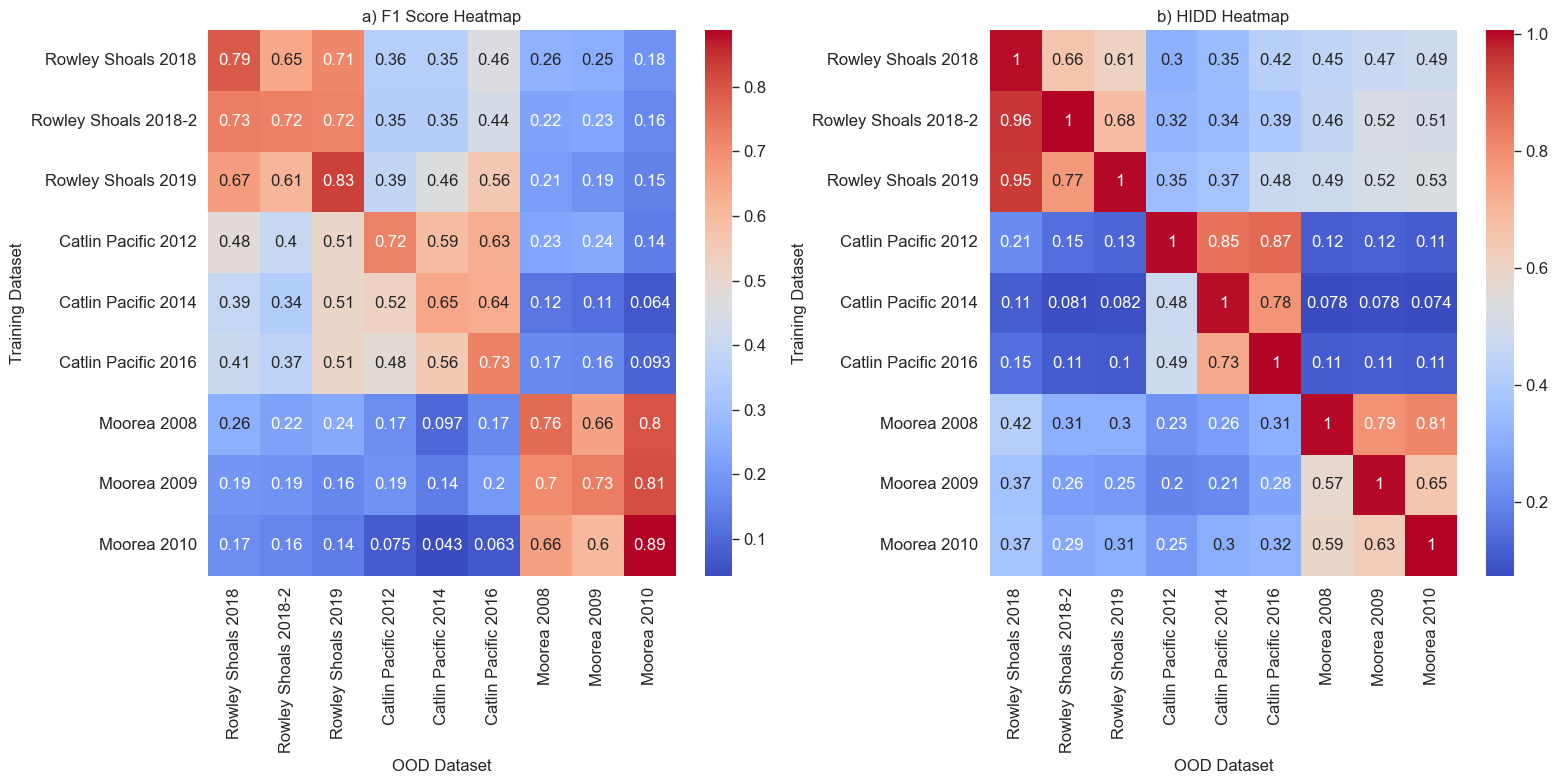

In [31]:
pivot_df = correlations_f1.dropna(subset=["hidd_global"])
pivot_df

df = pivot_df.pivot(index="trip", columns="trip_compare", values="f1_score")
df2 = pivot_df.pivot(index="trip", columns="trip_compare", values="hidd_global")

new_order = [
            "Rowley Shoals 2018",
            "Rowley Shoals 2018-2", 
            "Rowley Shoals 2019", 
            "Catlin Pacific 2012", 
            "Catlin Pacific 2014", 
            "Catlin Pacific 2016", 
            "Moorea 2008", 
            "Moorea 2009", 
            "Moorea 2010"]

df = df.reindex(new_order)
df2 = df2.reindex(new_order)
df = df[new_order]
df2 = df2[new_order]


#df["Col"] = df["Col"].cat.set_categories(category_order_list, ordered=True)

#fig = plt.figure(figsize = (8,3.5))
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12,"xtick.labelsize":12,
                             "ytick.labelsize":12,"legend.fontsize":12,"legend.title_fontsize":12,
                             "font.family": "sans-serif"})

# Create a DataFrame
#df = pd.DataFrame(data, index=['A', 'B', 'C'])
#df = heatmap_df.pivot(index="Dataset", columns="Label", values="Histogram Intersection")

#df_transposed = df.T

# Plotting the heatmap
#plt.figure(figsize=(8, 4))
#sns.heatmap(df, annot=True, cmap='coolwarm')
#plt.title('Heatmap Example')
#plt.show()

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first heatmap
sns.heatmap(df, ax=axes[0], annot=True, cmap='coolwarm')
axes[0].set_title('a) F1 Score Heatmap')
axes[0].set_ylabel('Training Dataset')
axes[0].set_xlabel('OOD Dataset')

# Plot the second heatmap
sns.heatmap(df2, ax=axes[1], annot=True, cmap='coolwarm')
axes[1].set_title('b) HIDD Heatmap')
axes[1].set_ylabel('Training Dataset')
axes[1].set_xlabel('OOD Dataset')

# Adjust layout
plt.tight_layout()

plt.savefig("heatmap_whole_dataset.png", format="png", dpi=300)

# Show the plot
plt.show()

